In [1]:
# Linear regression on ranks for top up regulated cell types with sampled tumor fraction

In [19]:
# Load packages
import re
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
# for PCC and it's scatter plot
from scipy import stats
import seaborn as sns

In [20]:
data = pd.read_csv("/mnt/DATA3/timo/centers/main/body/outputs/combined_518_FCC_final.csv")
# data['cell_type_tissue'] = data['cell_type'].str.replace('RNA.', '', regex=False)
compartment_map = pd.read_csv("/mnt/DATA3/timo/data/compartment_map.csv")
data

sample             status      tfx gender                                   cell_type_tissue  correlation  rank
0       EE88247        Lung Cancer  0.06508      M                       mature NK T cell_Bone Marrow    -0.137445     1
1       EE88247        Lung Cancer  0.06508      M                             type I NK T cell_Blood    -0.131413     2
2       EE88247        Lung Cancer  0.06508      M                             mature NK T cell_Blood    -0.131145     3
3       EE88247        Lung Cancer  0.06508      M                                 naive B cell_Blood    -0.130540     4
4       EE88247        Lung Cancer  0.06508      M  CD8 positive alpha beta cytokine secreting eff...    -0.129783     5
...         ...                ...      ...    ...                                                ...          ...   ...
231541  EE87867  Colorectal Cancer  0.02104      M                    bladder urothelial cell_Bladder     0.004231   443
231542  EE87867  Colorectal Cancer  0.02104      M       acinar cell of salivary gland_Salivary Gland     0.009547   444
231543  EE87867  Colorectal Cancer  0.02104      M                    type B pancreatic cell_Pancreas     0.009896   445
231544  EE87867  Colorectal Cancer  0.02104      M                                   stromal cell_Eye     0.012131   446
231545  EE87867  Colorectal Cancer  0.02104      M                                keratinocyte_Tongue     0.032794   447

[231546 rows x 7 columns]

In [5]:
## outliers
# remove EE87821 (breast cancer) and EE88267 (ovarian cancer) bc too high tfx, around 0.35
# and remove EE87787 bile duct cancer having tfx of 0.068 
# List of EE numbers to exclude
exclude_numbers = ["EE87821", "EE88267", "EE87787"]

# Filter out rows where 'sample' column matches the excluded values
data = data[~data["sample"].isin(exclude_numbers)]

In [6]:
data.shape

(230205, 7)

In [5]:
# # Function to extract cell name
# # List of removal words, equivalent to `removal_words` in R
# removal_words = ["Small", "Large", "Bone", "Salivary", "Lymph"]  # Add your removal words here

# # Define the pattern based on `removal_words`
# pattern = r"\.(" + "|".join(removal_words) + r")\."

# # Custom function to apply the transformation
# def mutate_cells(tissue):
#     if re.search(pattern, tissue):
#         # Remove the last and second-last words
#         return re.sub(r"\.[A-Za-z]+\.[A-Za-z]+$", "", tissue)
#     else:
#         # Remove only the last word
#         return re.sub(r"\.[A-Za-z]+$", "", tissue)

In [7]:
cancer_types = list(data["status"].unique())
cancer_types.remove('Healthy')
print(cancer_types)

['Lung Cancer', 'Breast Cancer', 'Pancreatic Cancer', 'Ovarian Cancer', 'Bile Duct Cancer', 'Colorectal Cancer', 'Gastric cancer']


In [7]:
# data.groupby('sample')['cell_type'].nunique()

In [9]:
len(data["cell_type_tissue"].unique())

447

In [11]:
dic = {}
for cancer_type in cancer_types:
    # print(cancer_type)
    gender = data[data["status"] == cancer_type]["gender"].unique()
    subset_data = data[(data['status'].isin(["Healthy", cancer_type])) & (data['gender'].isin(gender))]

    # Initialize an empty list to store results
    subdic = {}

    for cell_type_oi in set(subset_data["cell_type_tissue"]):
        # print(cell_type_oi)
        subsub= subset_data[subset_data["cell_type_tissue"]==cell_type_oi]
        # take inverted rank for PCC calculation
        subsub_copy = subsub.copy()
        subsub_copy['inverted_ranks'] = len(data["cell_type_tissue"].unique()) - subsub['rank'] # 447 - rank
        # Calculate PCC and p-value
        pcc_inv, p_value = stats.pearsonr(subsub_copy['tfx'], subsub_copy['inverted_ranks'])
        subdic[cell_type_oi] = {'PCC': pcc_inv, 'p_value': p_value, 'df':subsub}

    dic[cancer_type] = subdic
print("Done.")

Done.


In [12]:
# take for each cancer type the cells having top 10 lowest and highest PCC values for plotting
plot_dic = {}

for cancer_type in dic.keys():
    sub_dic = dic[cancer_type]
    
    # Extract all 'PCC' values along with their respective cell types
    pcc_values = [(cell_type, v['PCC']) for cell_type, v in dic[cancer_type].items()]

    # Sort the list by PCC value in descending order
    sorted_pcc = sorted(pcc_values, key=lambda x: x[1], reverse=True)

    # Get the top 10 highest PCC values and their associated cell types
    top_10_highest_pcc = sorted_pcc[:10]

    # Get the top 10 lowest PCC values and their associated cell types (reverse the sorting order)
    top_10_lowest_pcc = sorted_pcc[-10:]#[::-1] for reversed order
    
    cells_lowest_highest_pcc = (top_10_highest_pcc+top_10_lowest_pcc)
    # Extract the cell types from the list
    cell_types_to_select = [cell for cell, pcc in cells_lowest_highest_pcc]

    # Filter the sub-dictionary to include only the selected cells
    filtered_cancer_subdic = {cell_type: sub_dic[cell_type] 
                                         for cell_type in cell_types_to_select 
                                         if cell_type in sub_dic}
    plot_dic[cancer_type] = filtered_cancer_subdic


Lung Cancer
Summary statistics based on foldchange


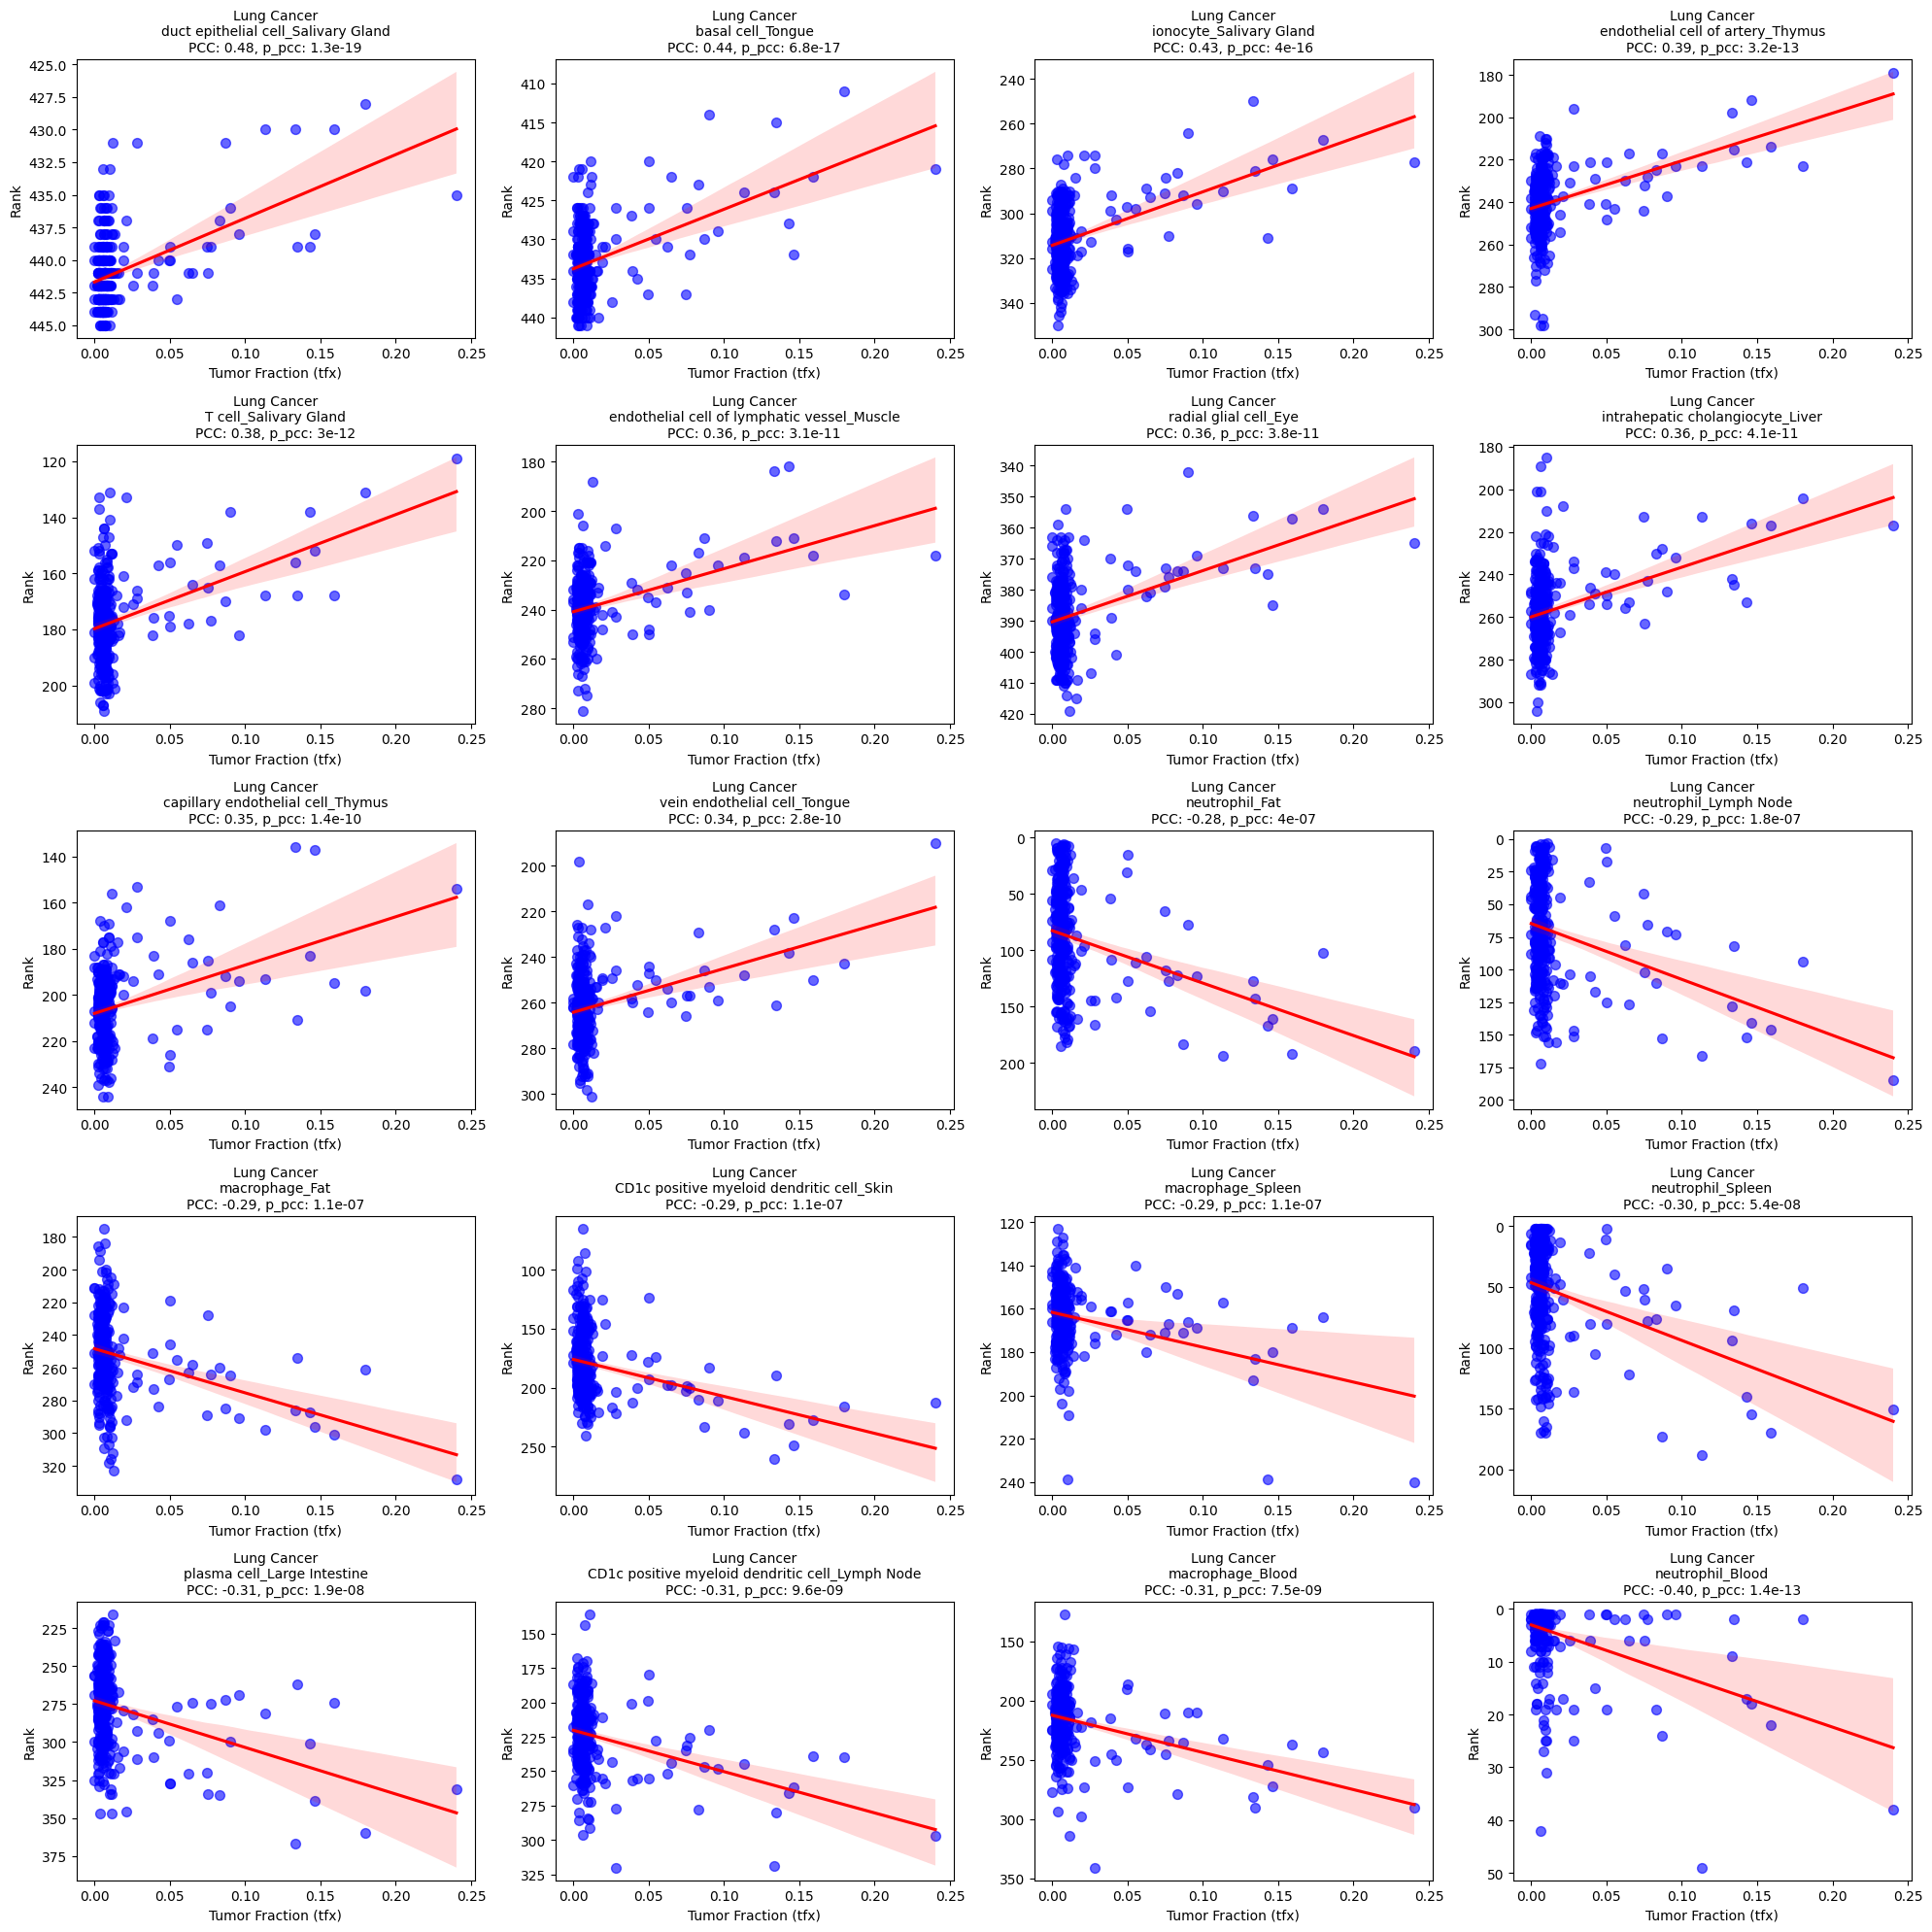

Breast Cancer
Summary statistics based on foldchange


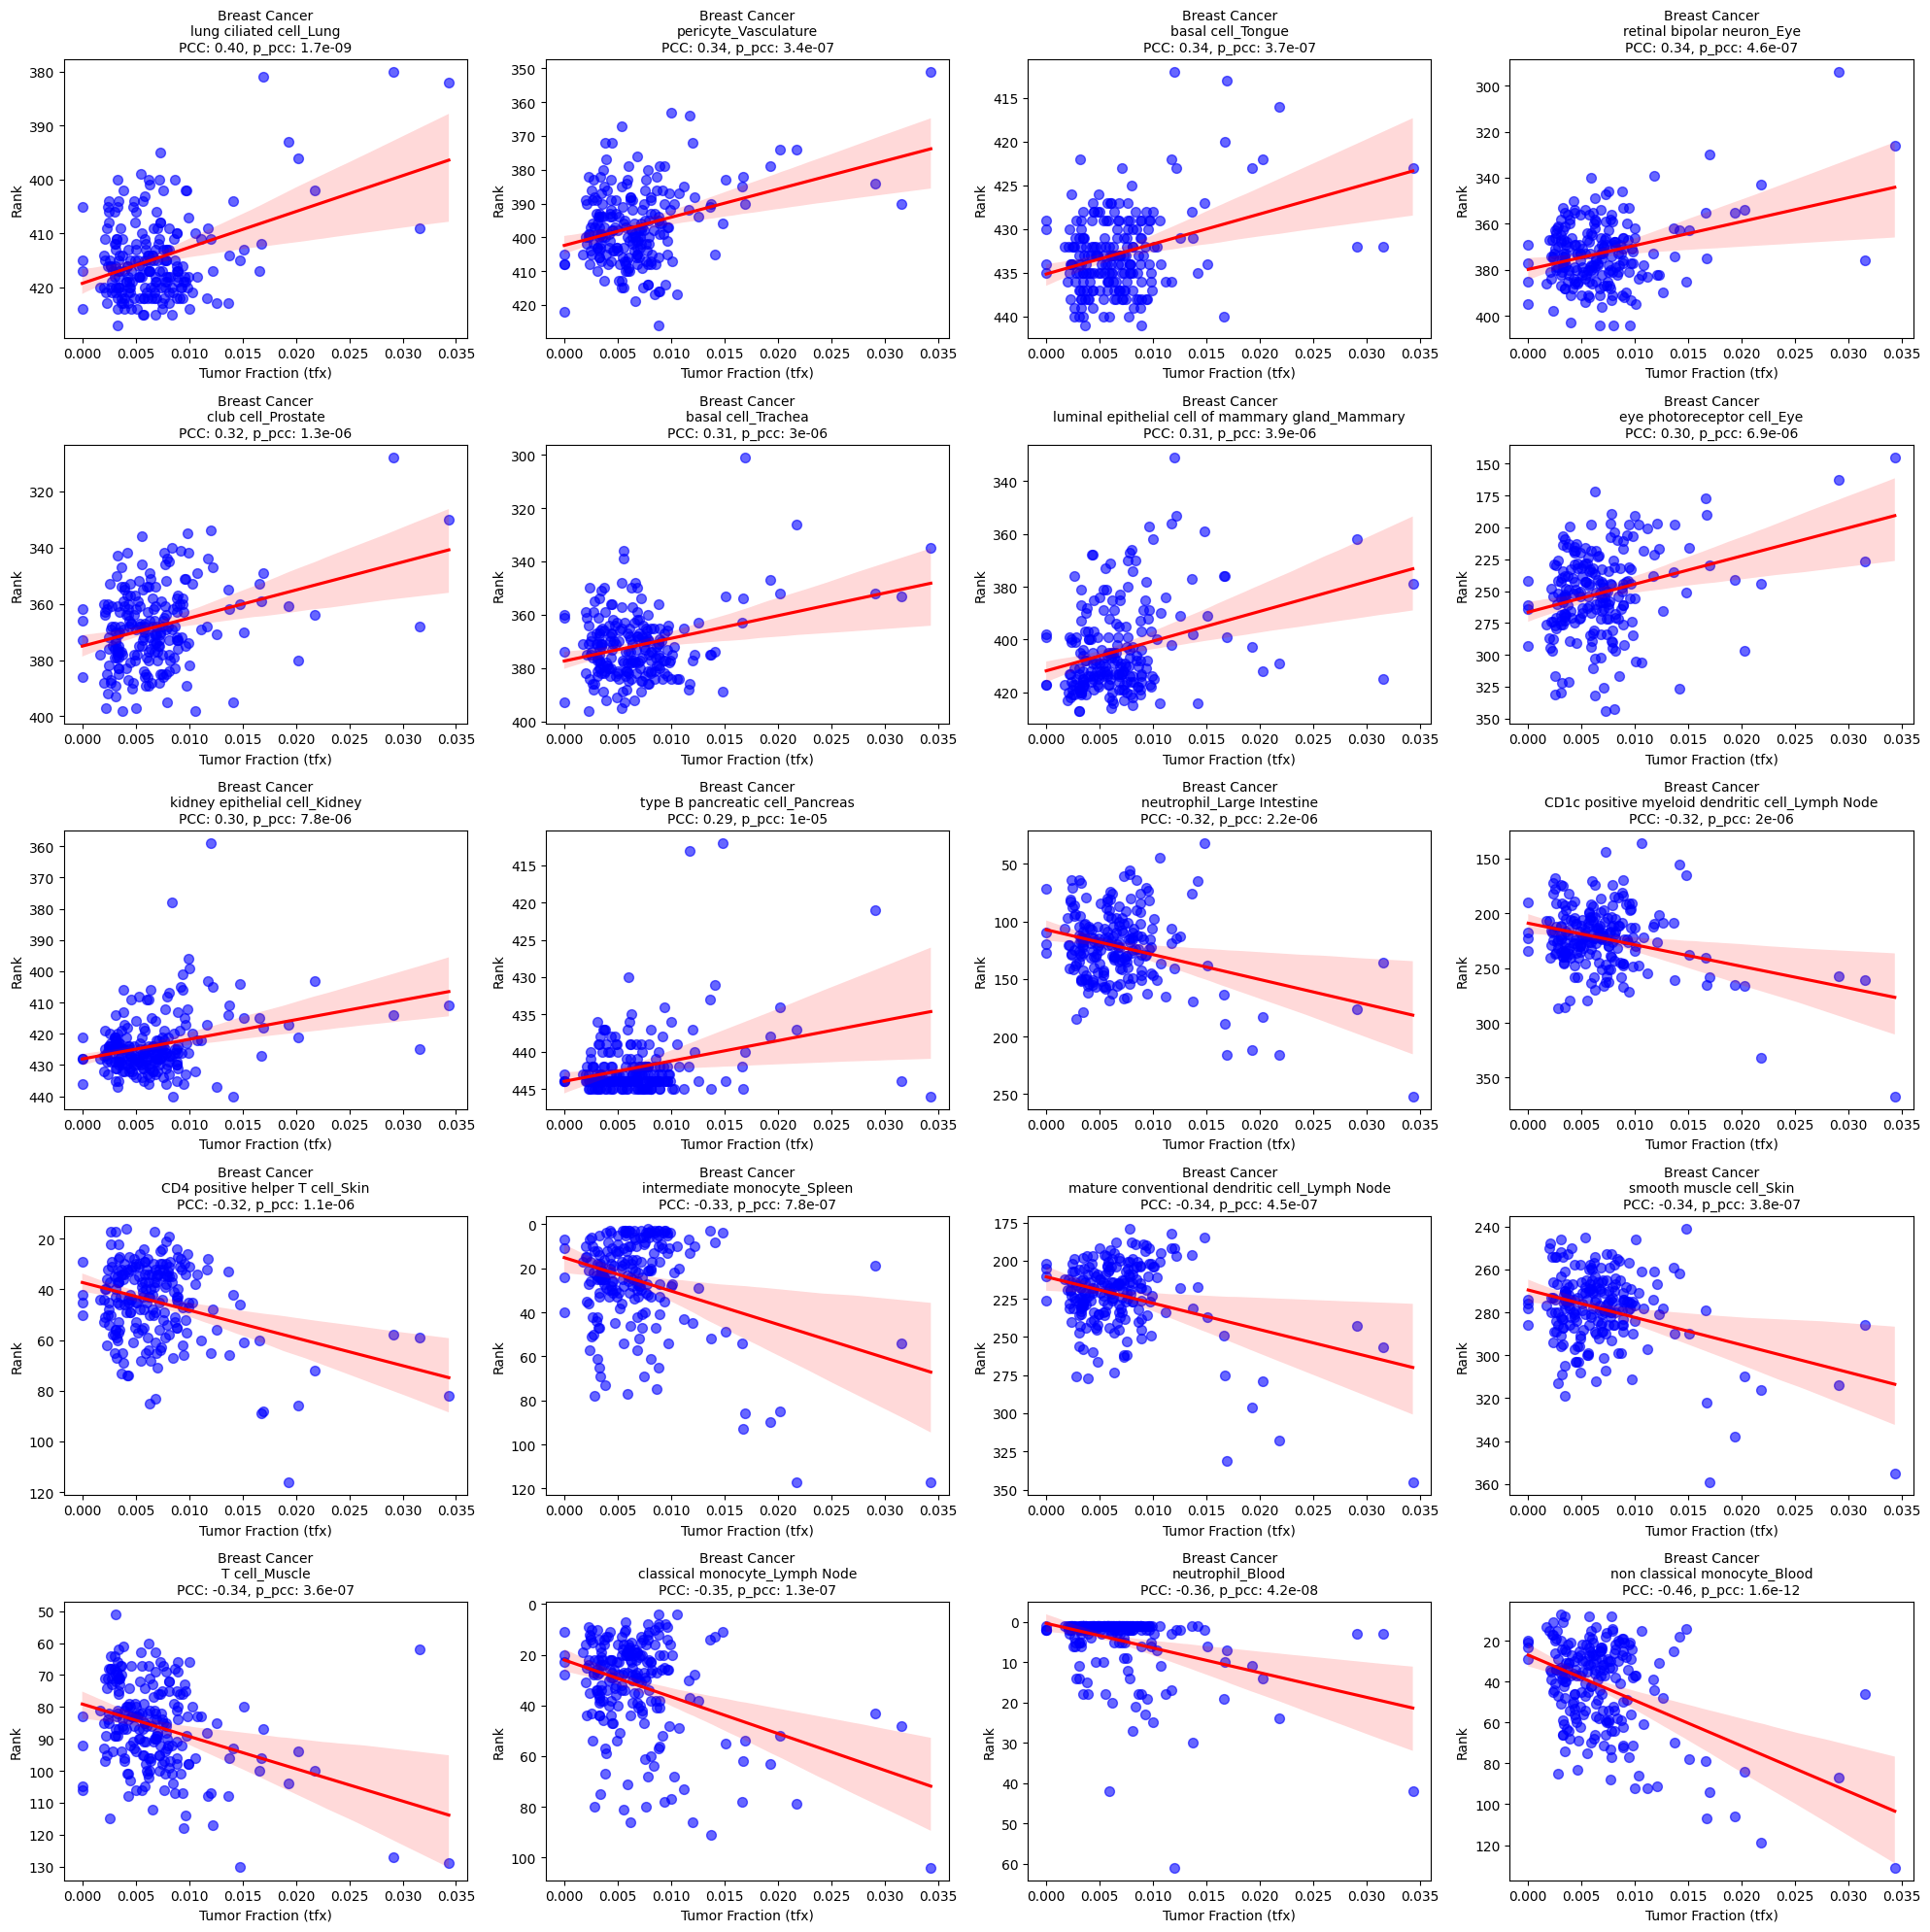

Pancreatic Cancer
Summary statistics based on foldchange


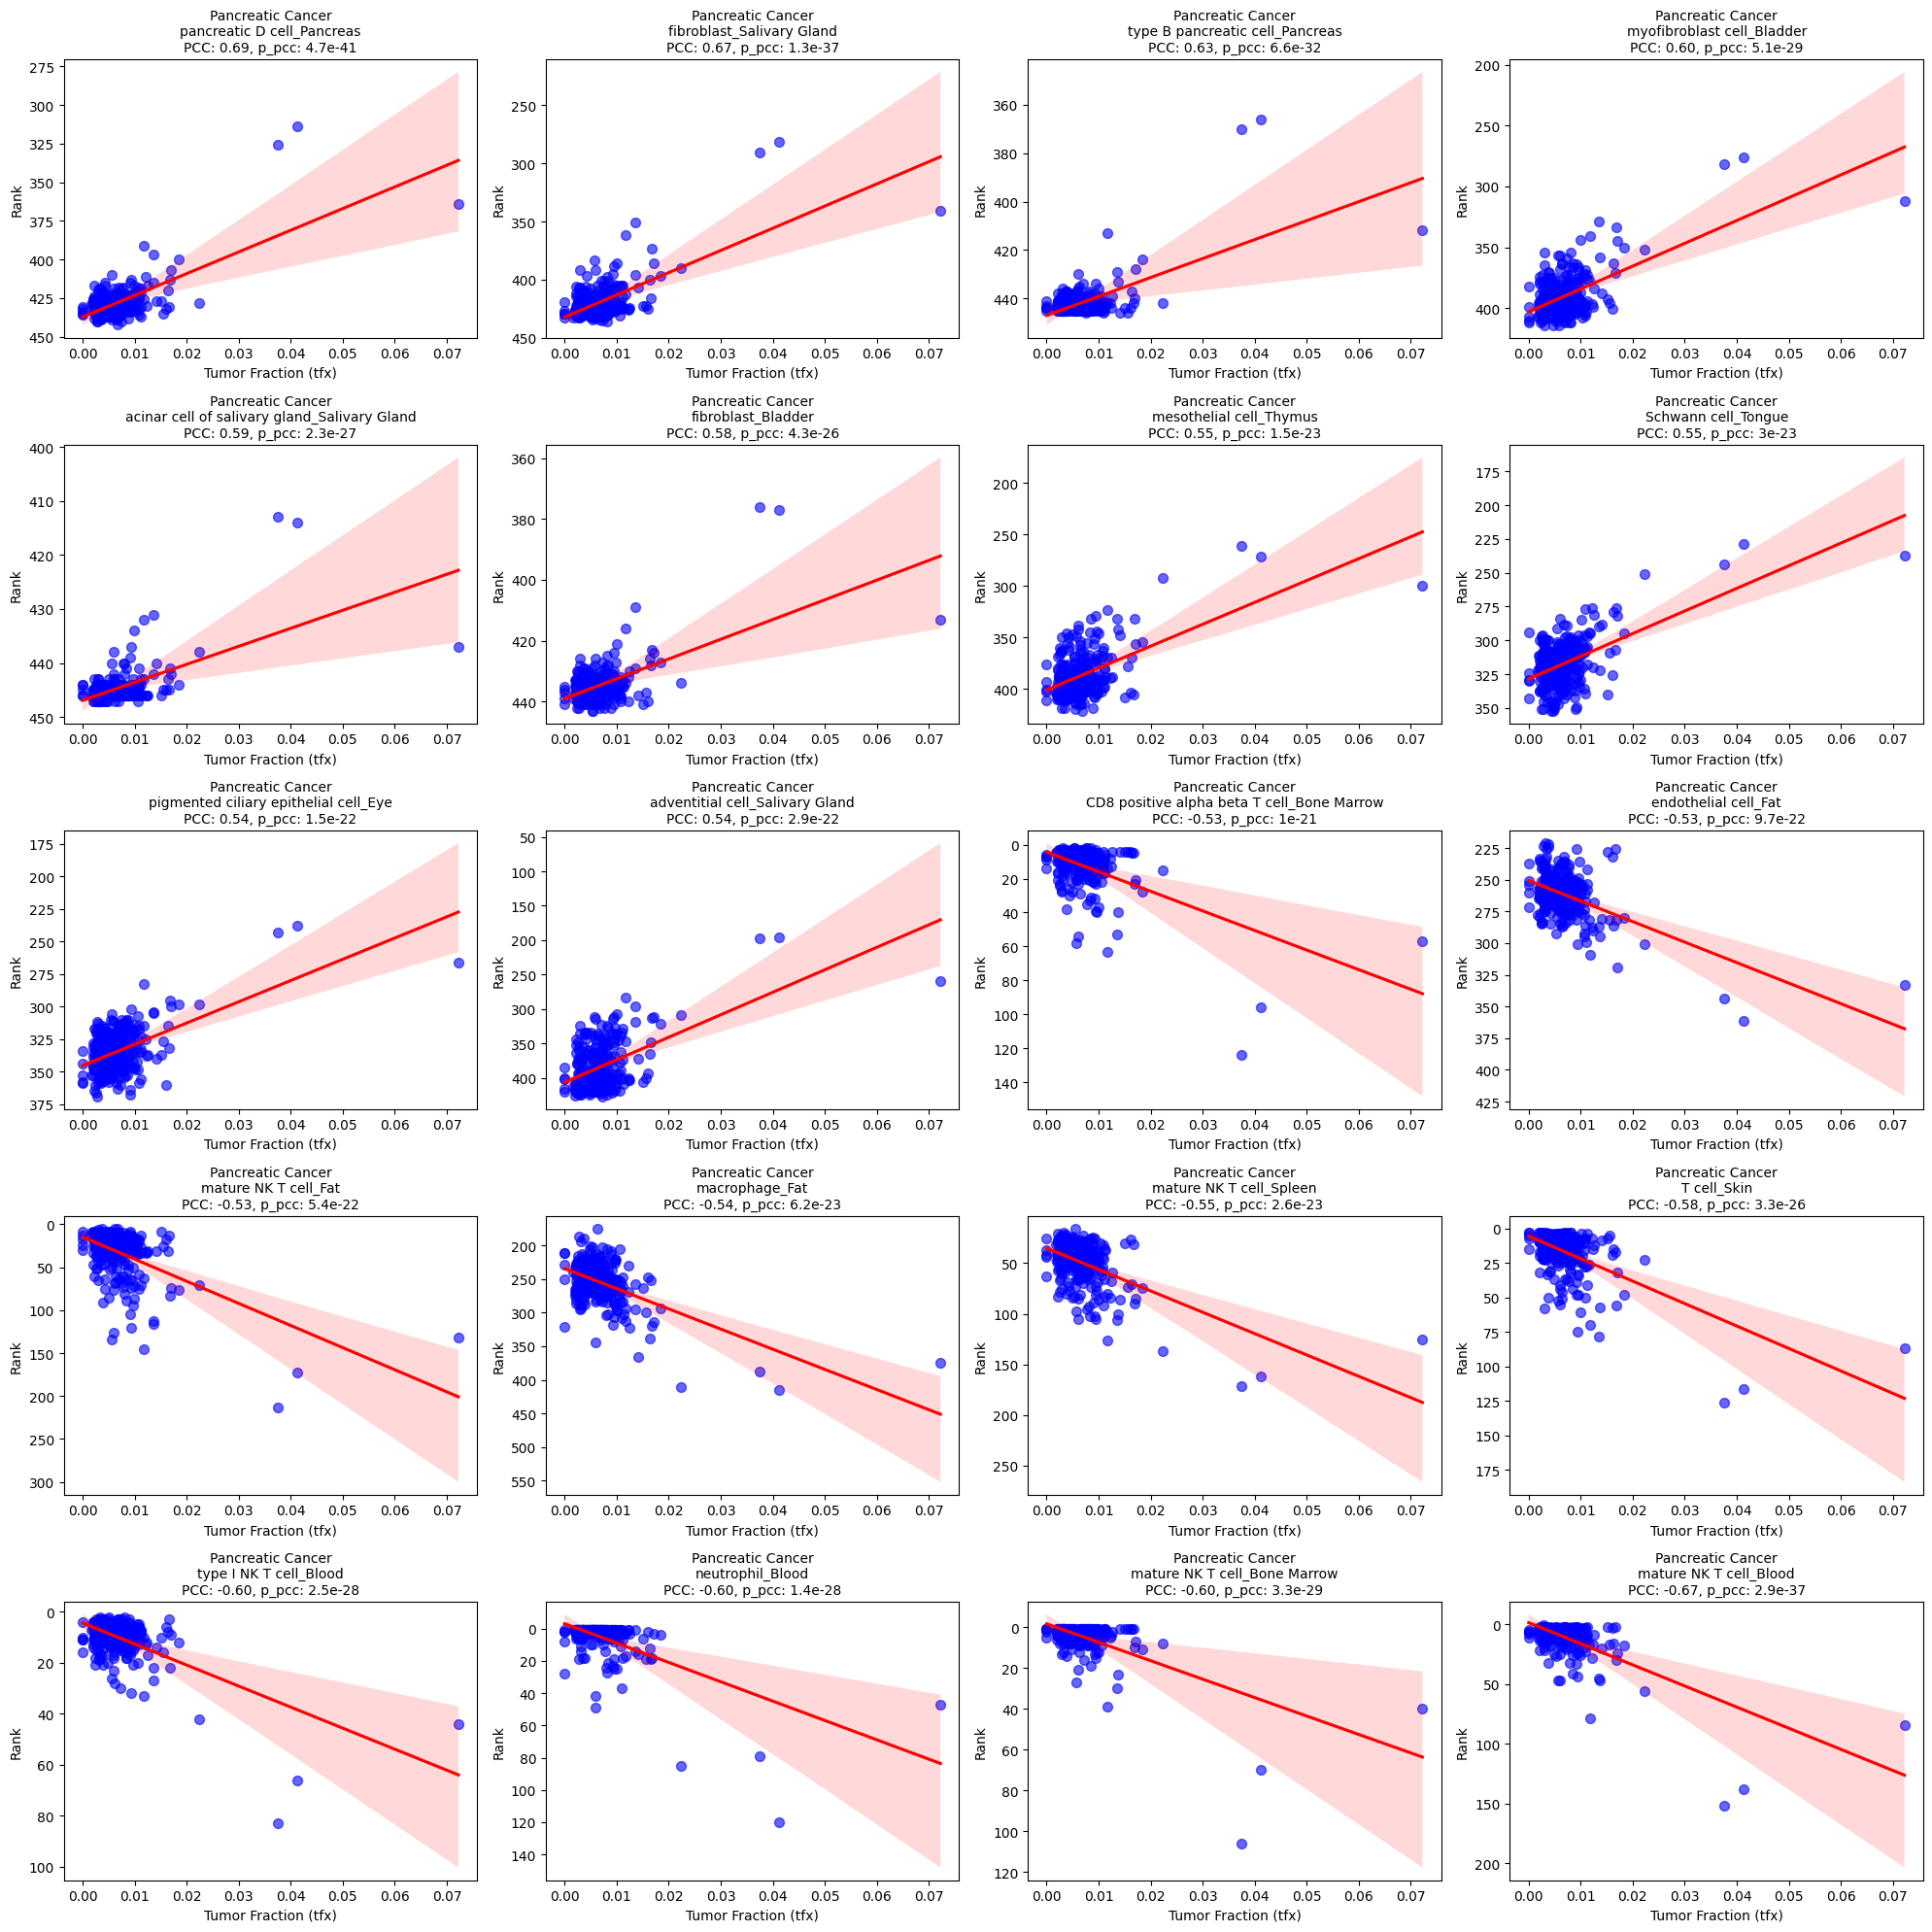

Ovarian Cancer
Summary statistics based on foldchange


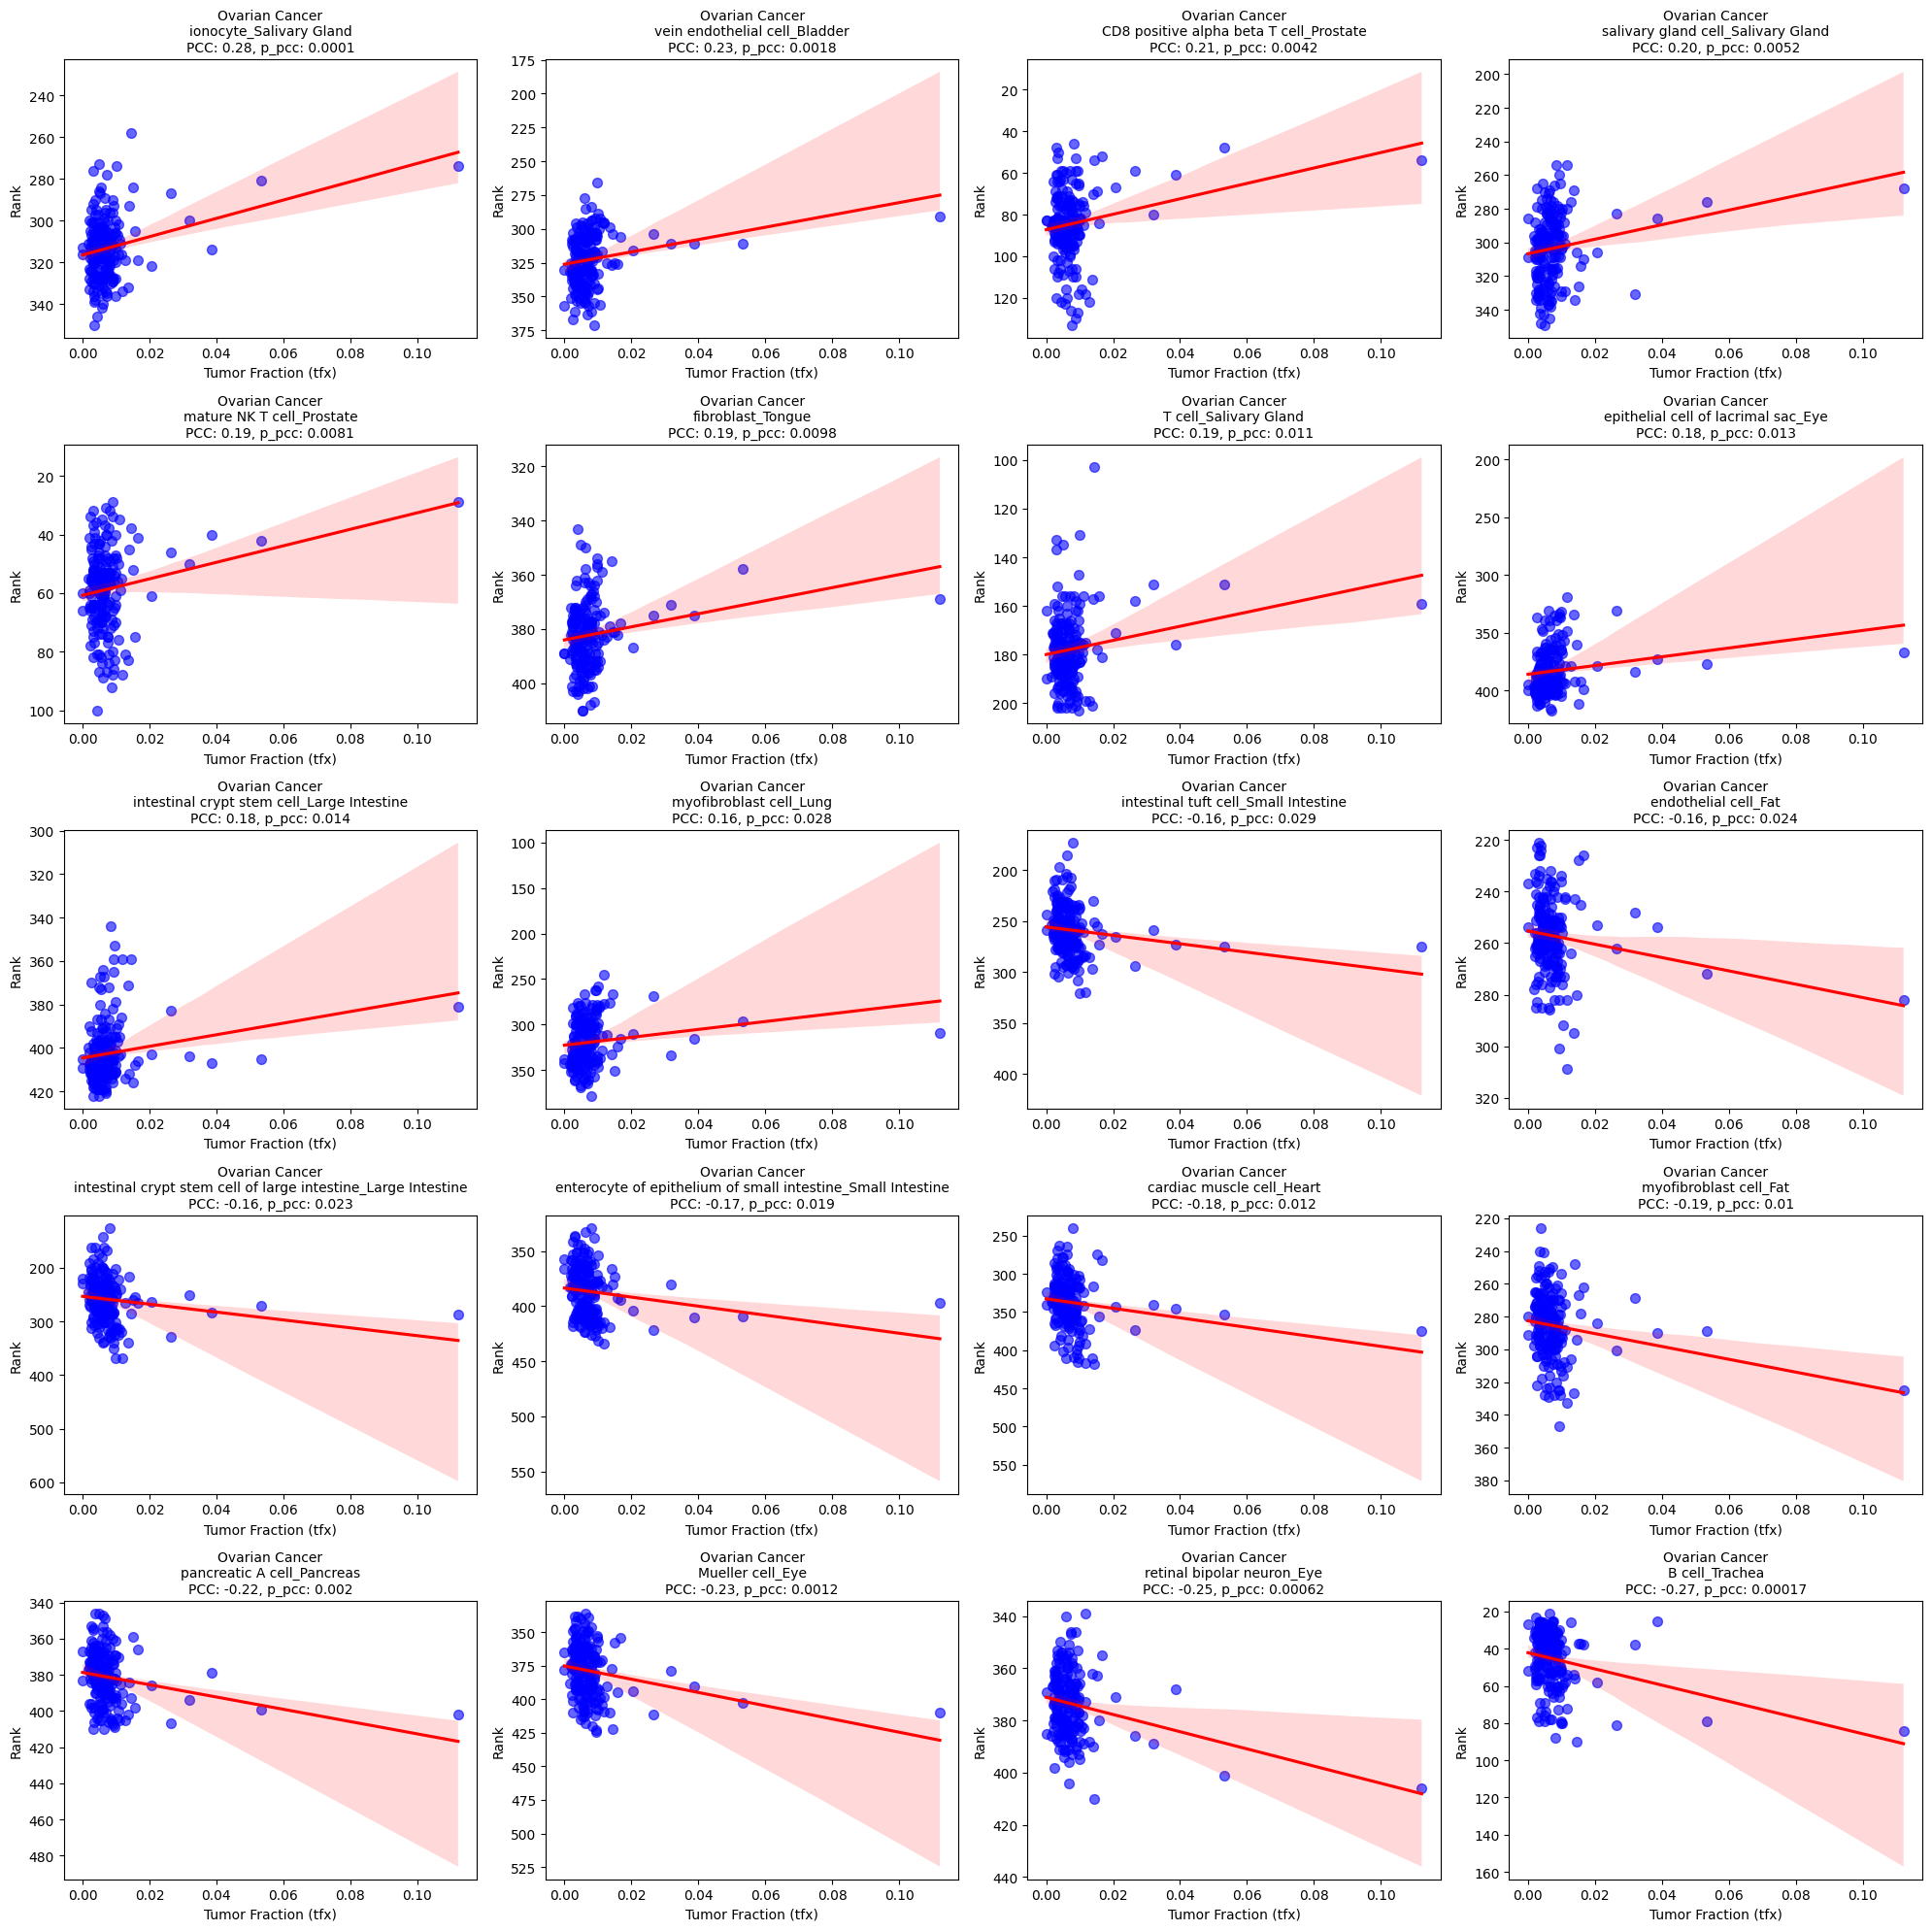

Bile Duct Cancer
Summary statistics based on foldchange


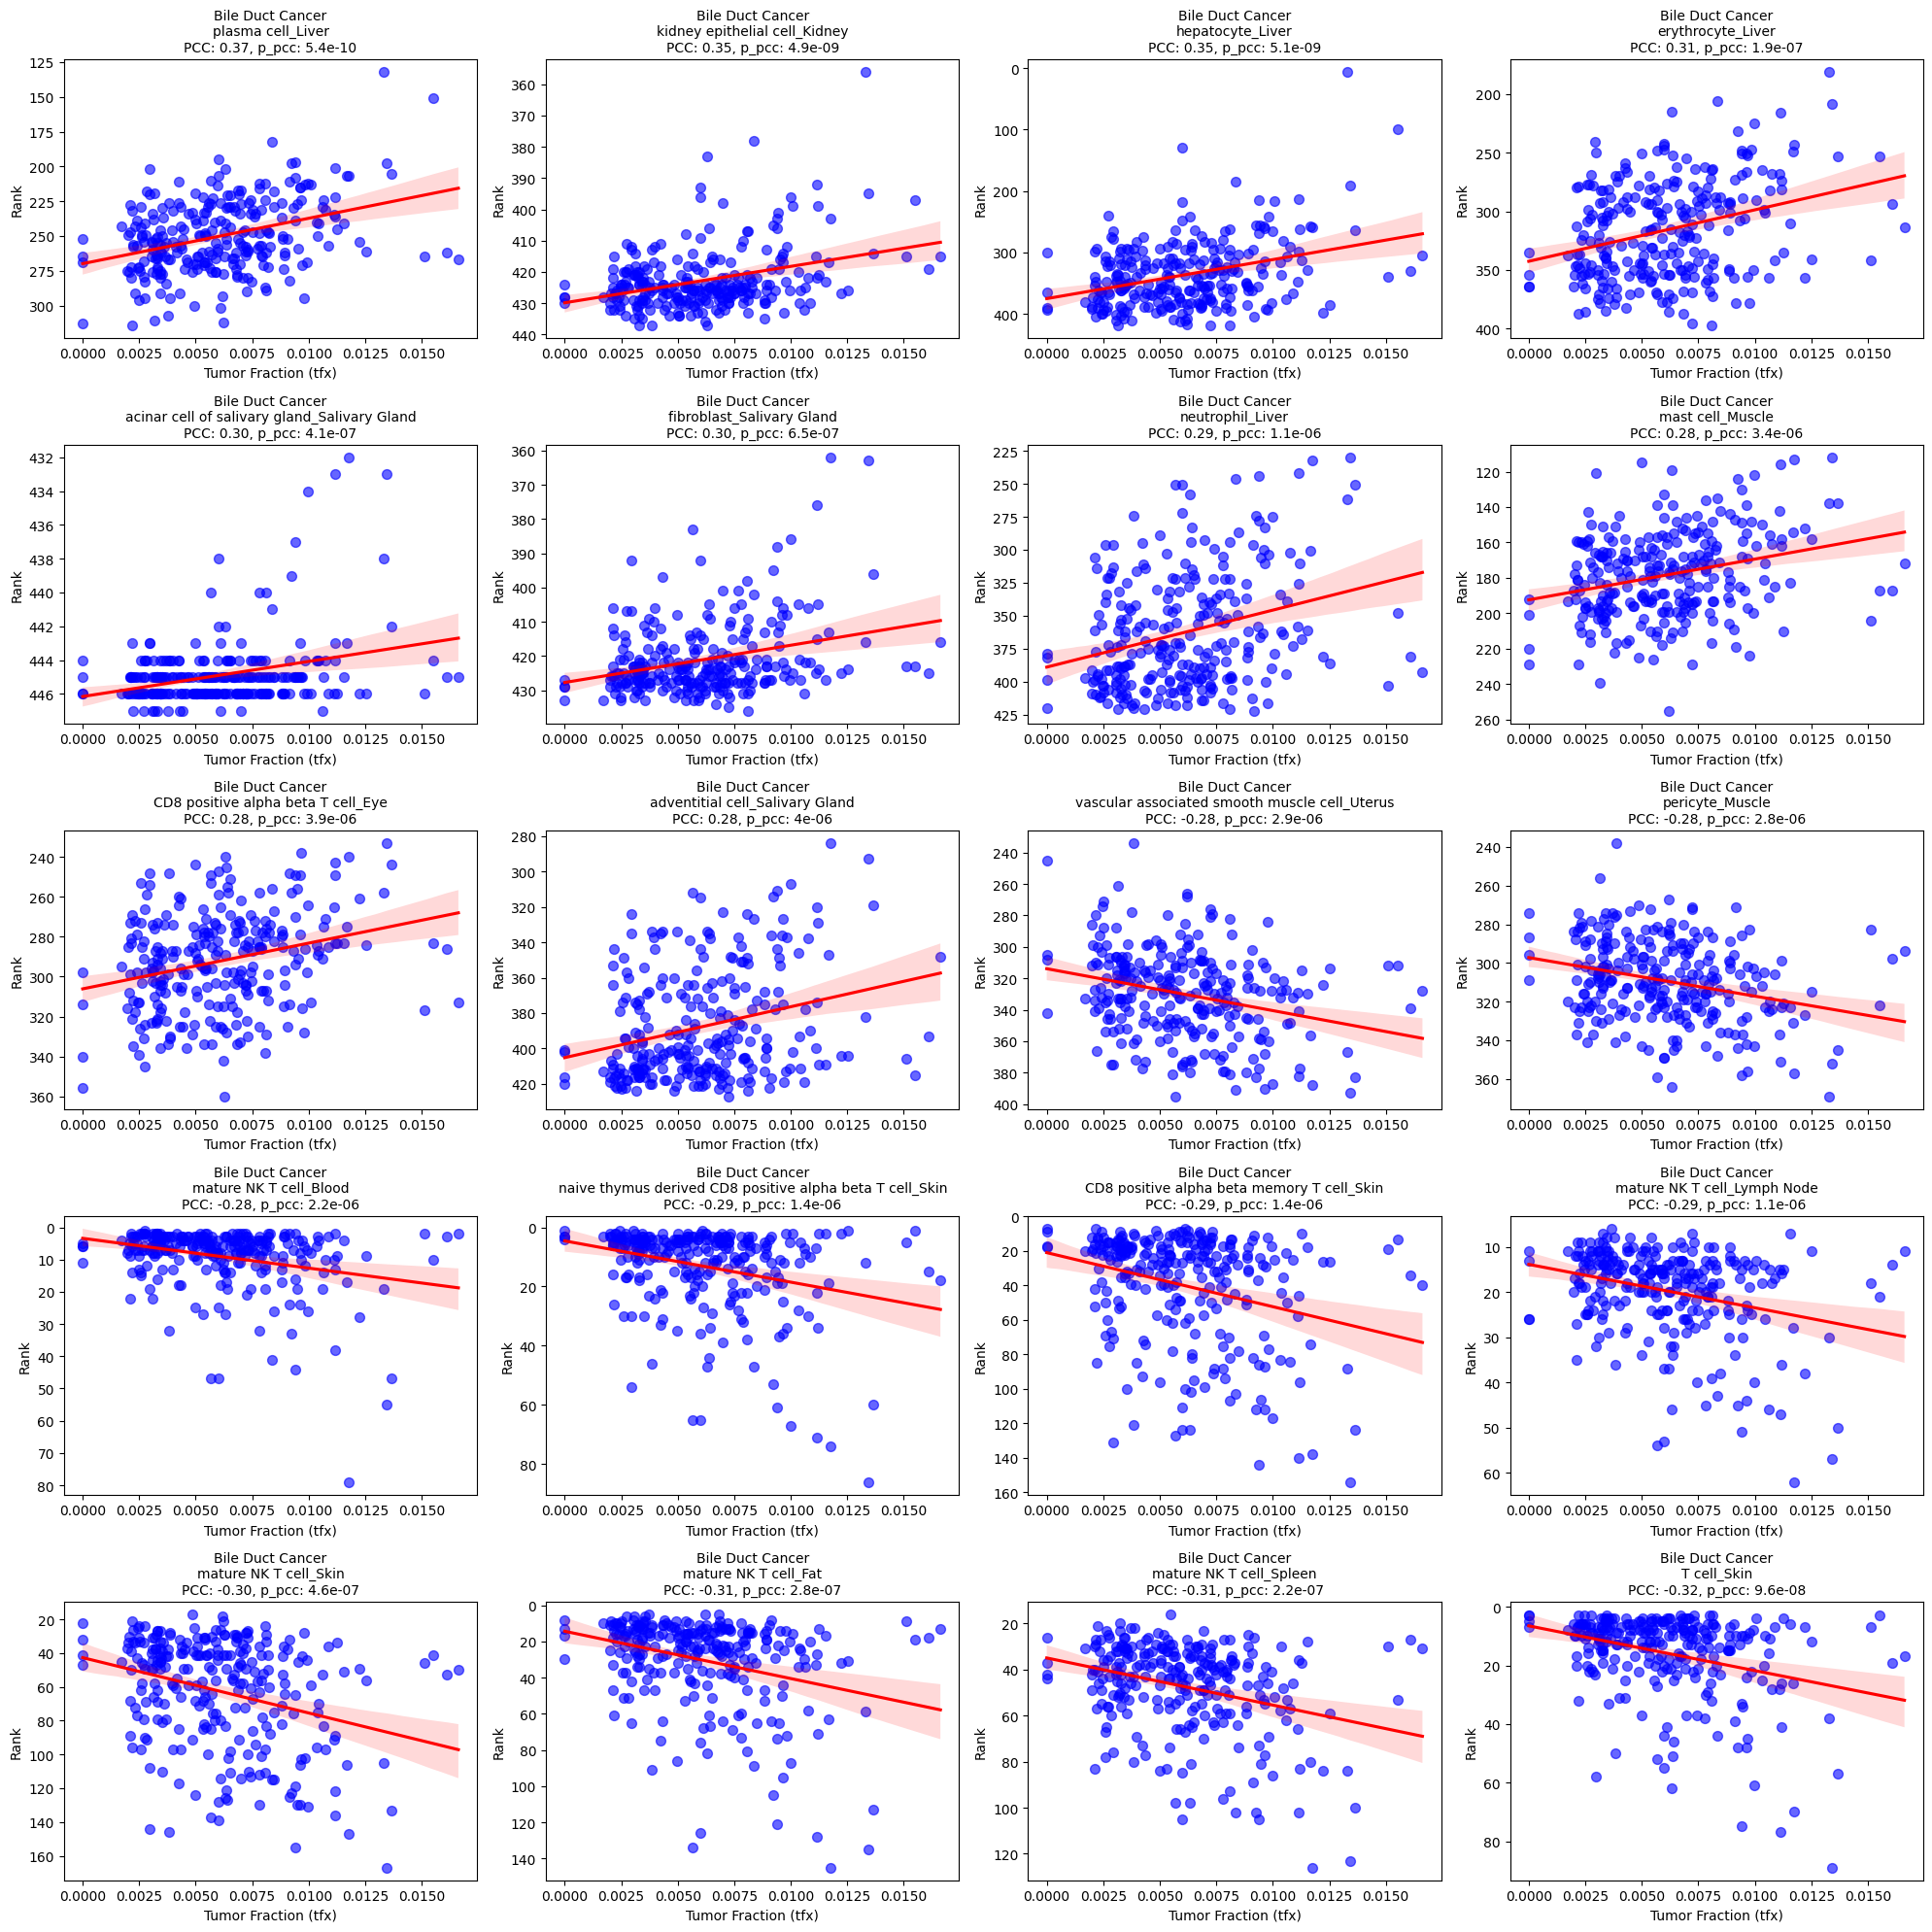

Colorectal Cancer
Summary statistics based on foldchange


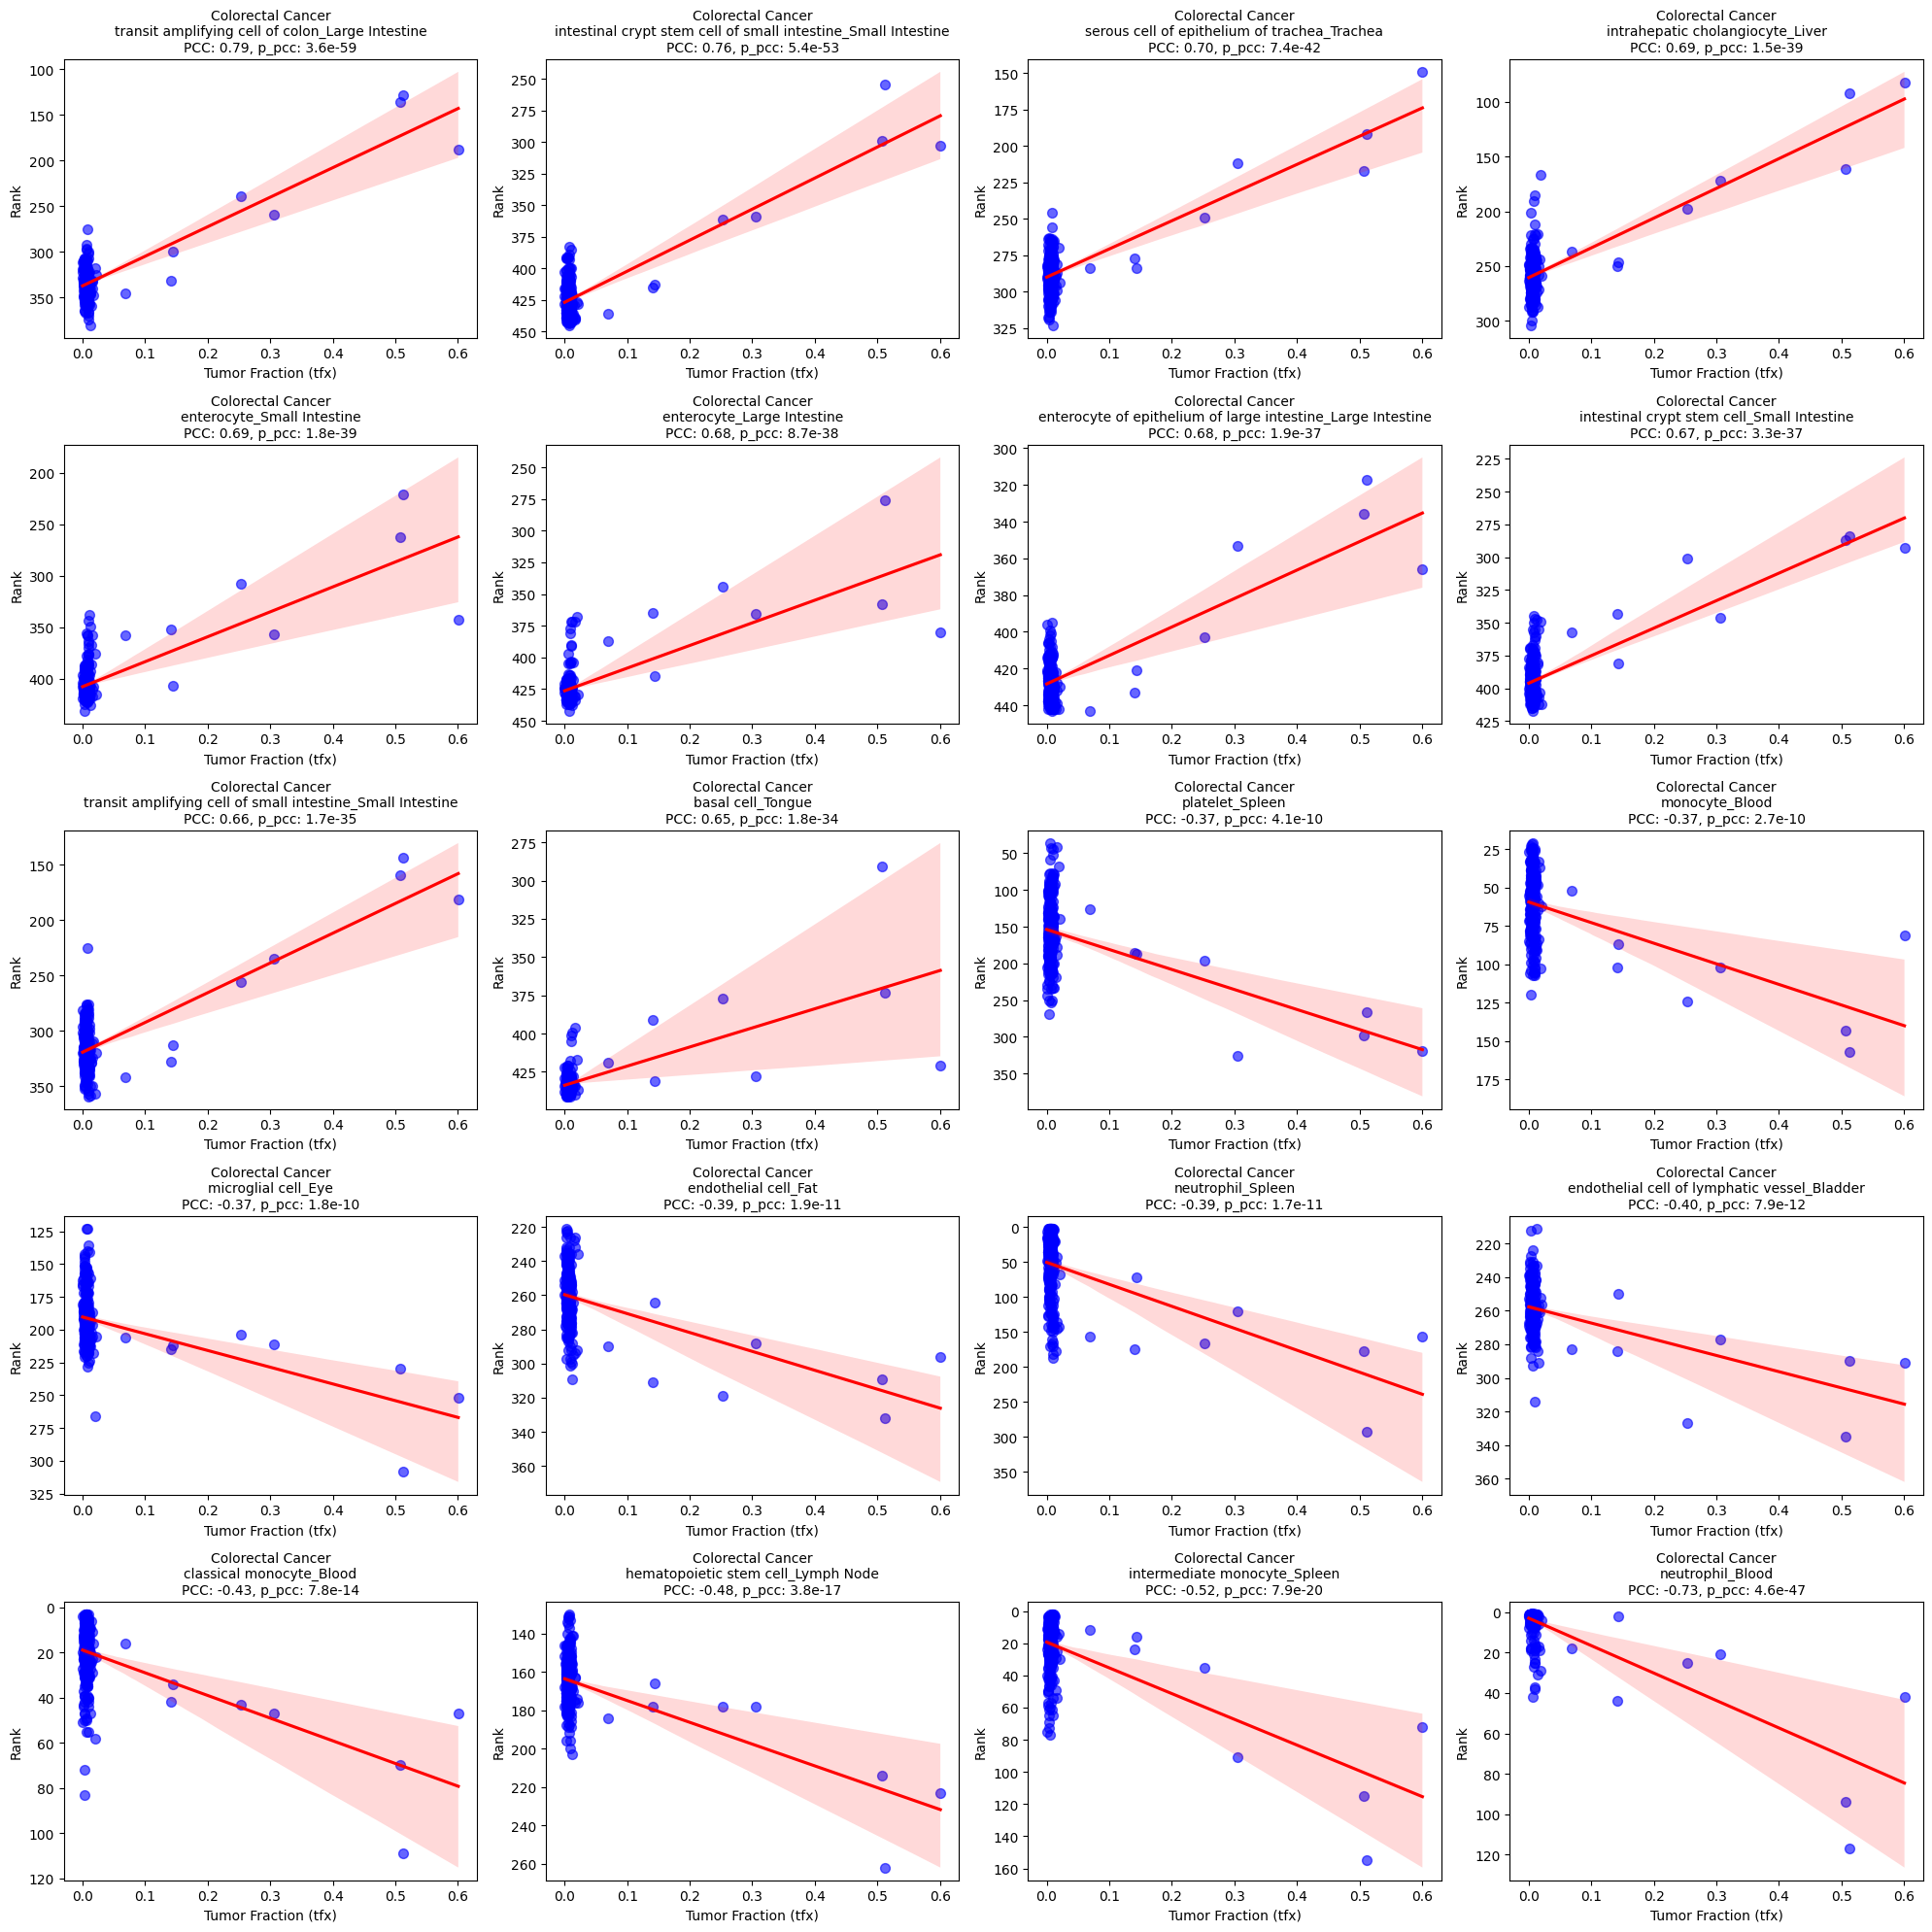

Gastric cancer
Summary statistics based on foldchange


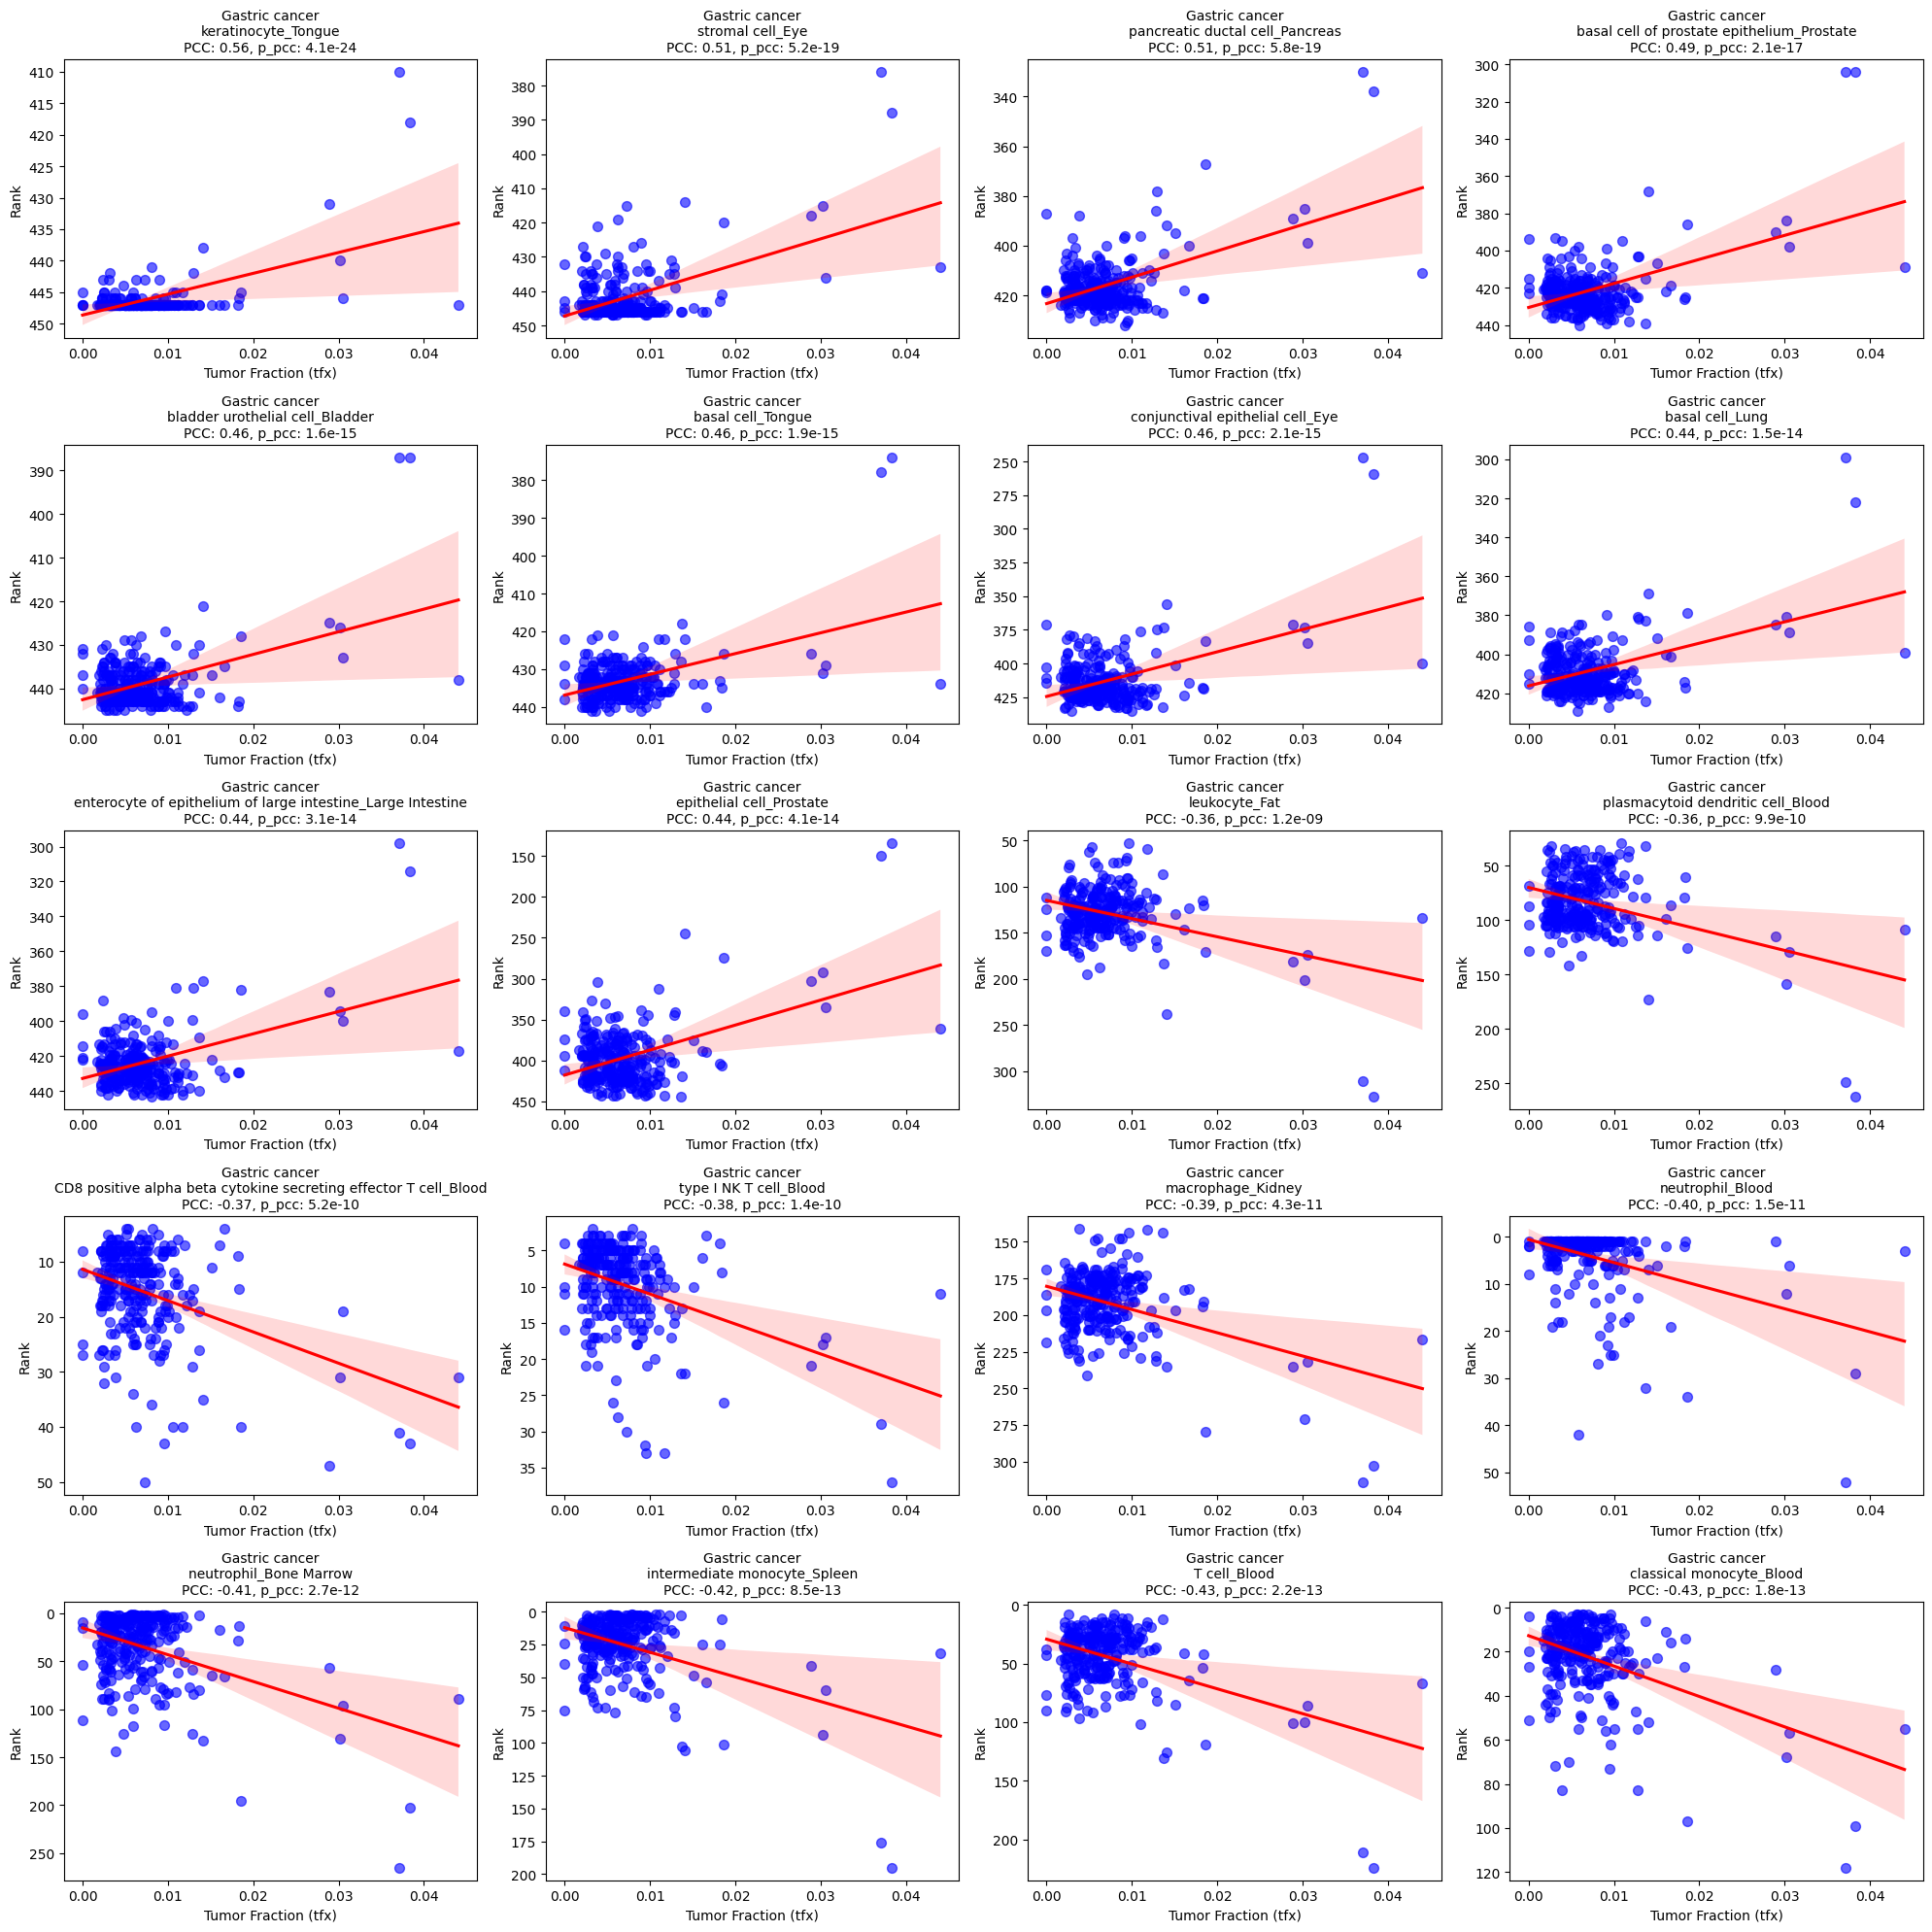

In [13]:
for cancer_type in dic.keys():
    print(cancer_type)
    # Create a figure and a set of subplots
    fig, axs = plt.subplots(5, 4, figsize=(20, 20))

    # Flatten axs array for easy iteration
    axs = axs.flatten()
    plot_count = 0
    for cell_type in plot_dic[cancer_type].keys():
        p_value_pcc = plot_dic[cancer_type][cell_type]['p_value']
        PCC = plot_dic[cancer_type][cell_type]['PCC']
        df = plot_dic[cancer_type][cell_type]['df']
        #summary = plot_dic[cancer_type][cell_type]['summary']
        #compartment = compartment_map[compartment_map["cells"]==(cell_type)]["compartment"]
        #compartment = list(compartment)[0]
        #wilcoxon_df = plot_dic[cancer_type][cell_type]['wilcoxon']
        #FC = list(wilcoxon_df[wilcoxon_df["cell_type"] == cell_type]["foldchange"])[0]
        #p_value_fc = list(wilcoxon_df[wilcoxon_df["cell_type"] == cell_type]["p"])[0]

        # Plotting on the current subplot axis
        sns.regplot(x='tfx', y='rank', data=df,
                    scatter_kws={'color': 'blue', 's': 50, 'alpha': 0.6},
                    line_kws={'color': 'red'}, ax=axs[plot_count])

        # Set the title and labels for each subplot
        axs[plot_count].set_title(f'{cancer_type}\n{cell_type}\nPCC: {PCC:.2f}, p_pcc: {p_value_pcc:.2g}', fontsize = 10)
        axs[plot_count].set_xlabel('Tumor Fraction (tfx)')
        axs[plot_count].set_ylabel('Rank')
        #axs[plot_count].set_ylim(0, 450)
        axs[plot_count].invert_yaxis()  # Invert y-axis to show higher rank at the top
        
        plot_count += 1
        # Stop after plotting 15 plots (or you can adjust this based on your grid size)
        #if plot_count >= rows * cols:
         #   break
            # Adjust layout to prevent overlapping
    print("Summary statistics based on foldchange")
    #print(up)
    # Adjust display settings
    pd.set_option('display.width', 1000)
    pd.set_option('display.max_columns', None)
    plt.tight_layout()

    # Show the final plot
    plt.show()

Lung Cancer


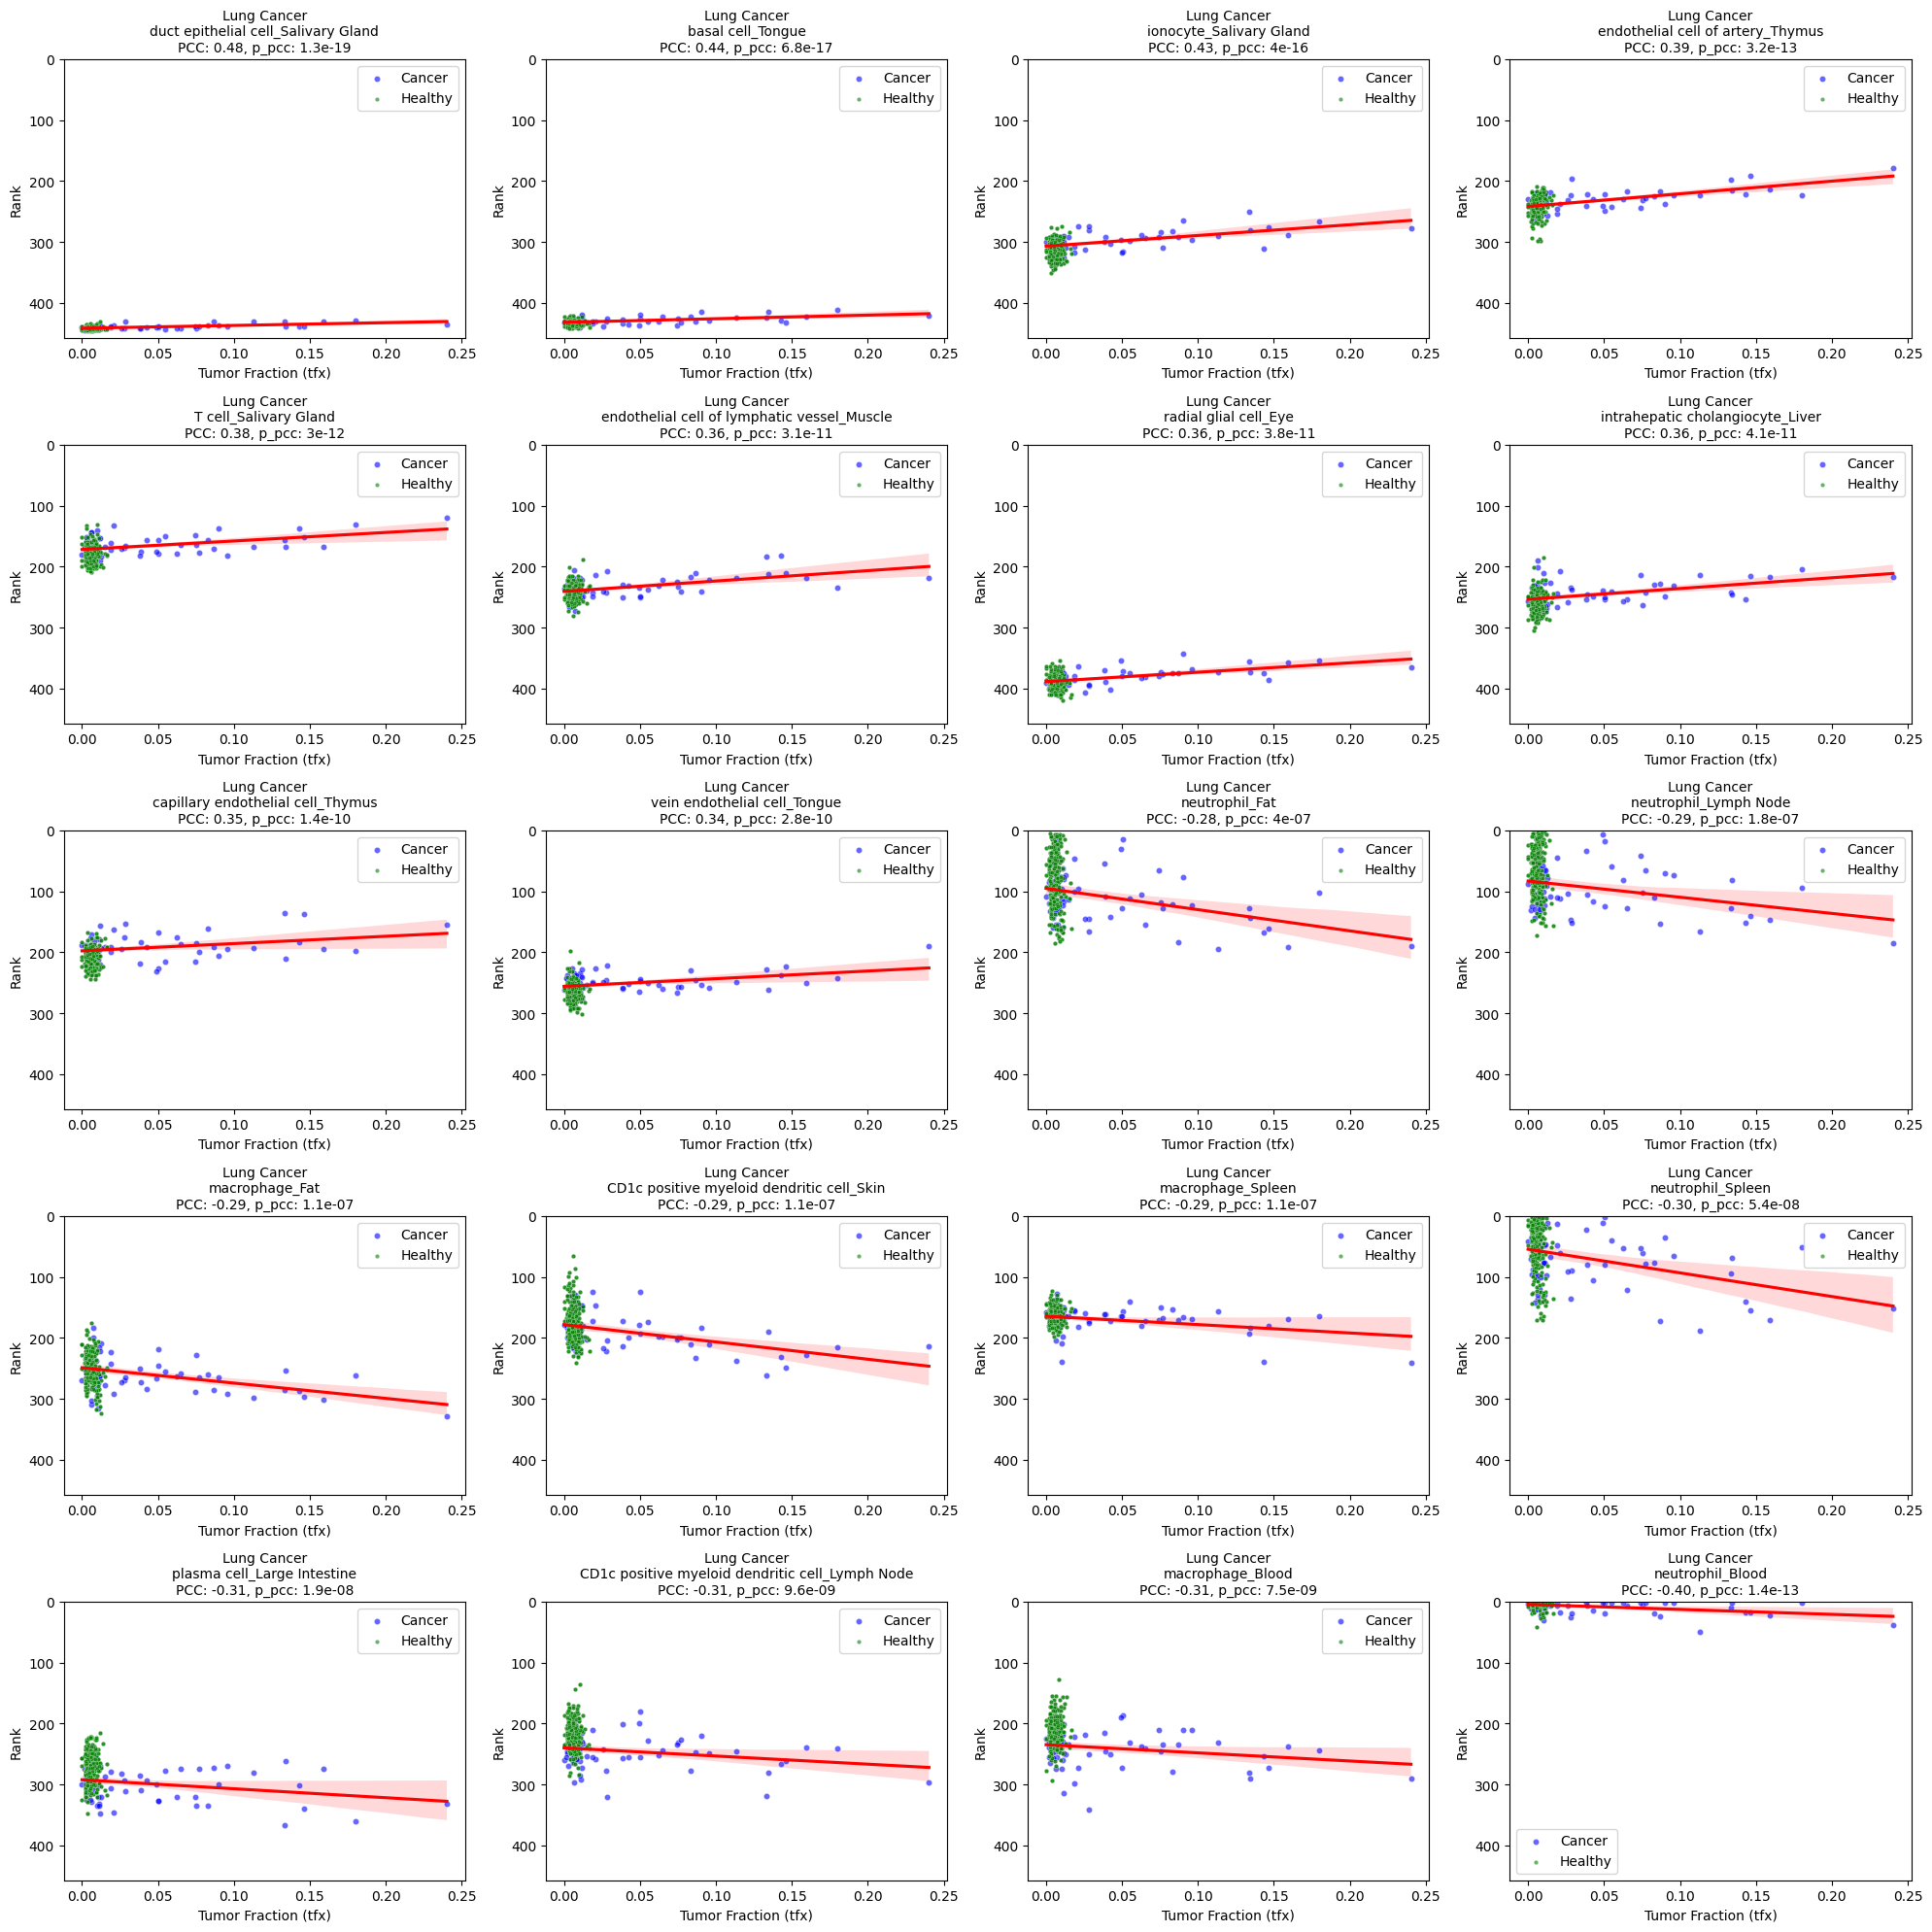

Breast Cancer


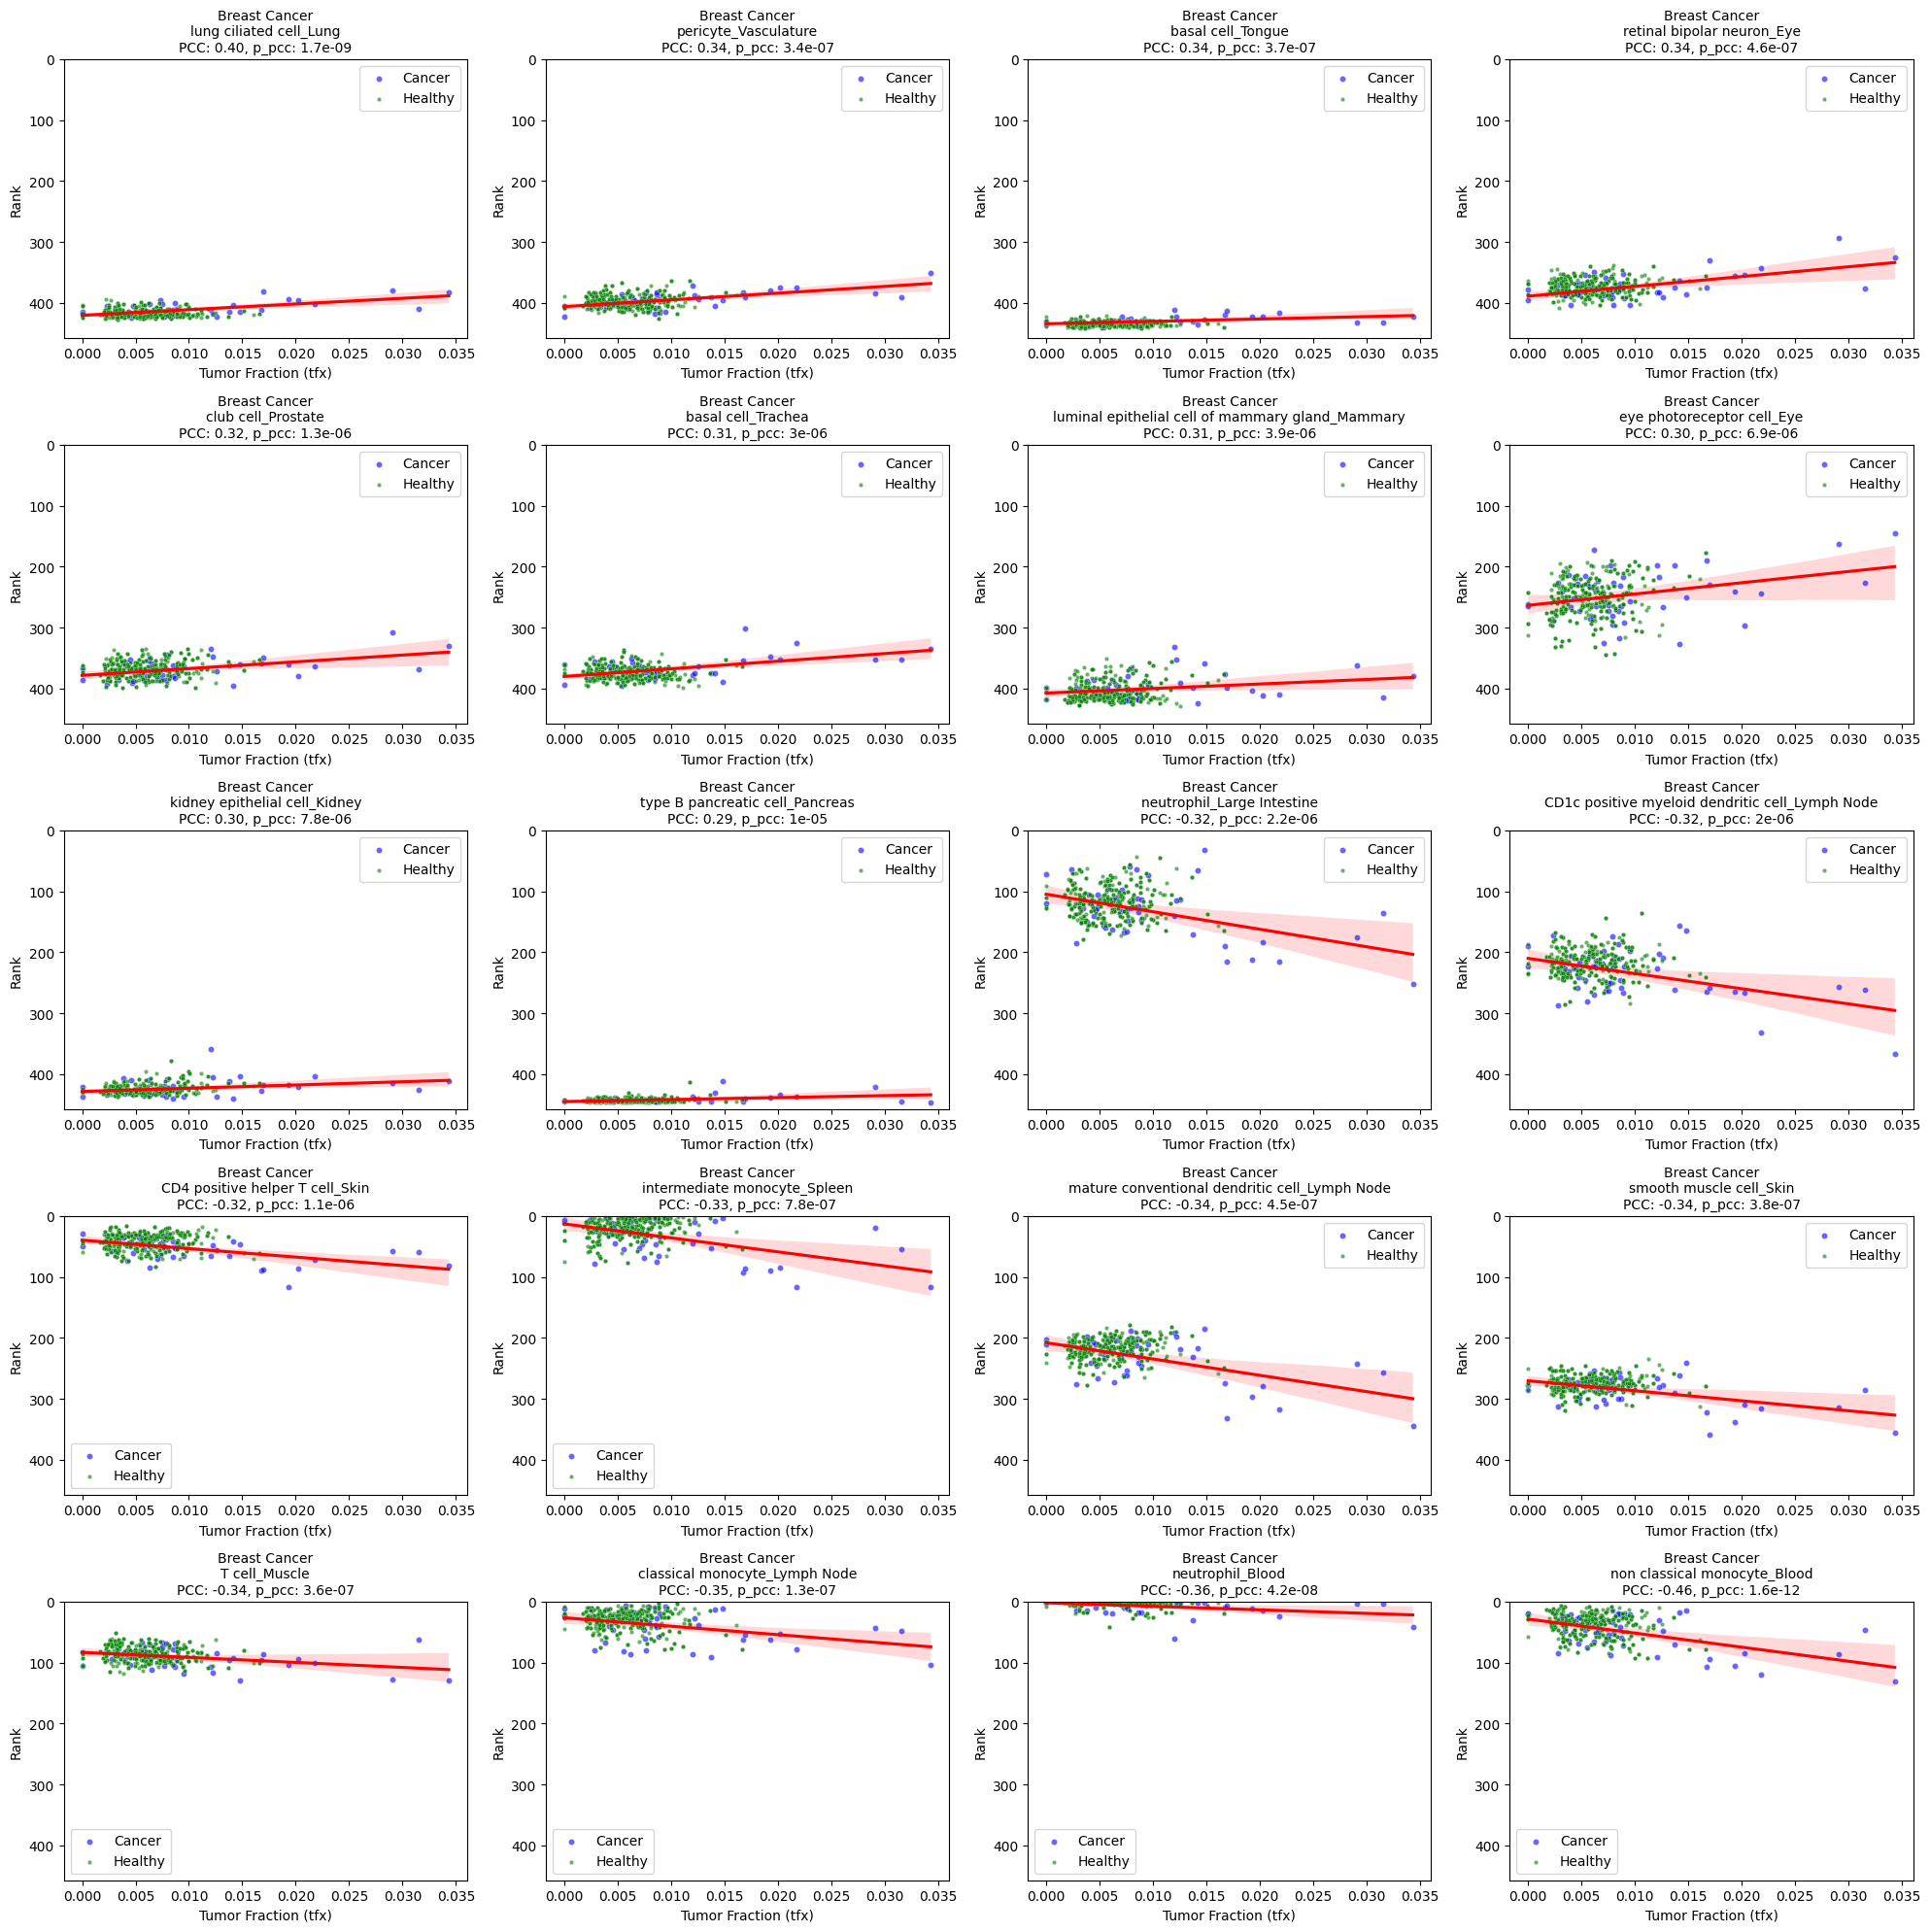

Pancreatic Cancer


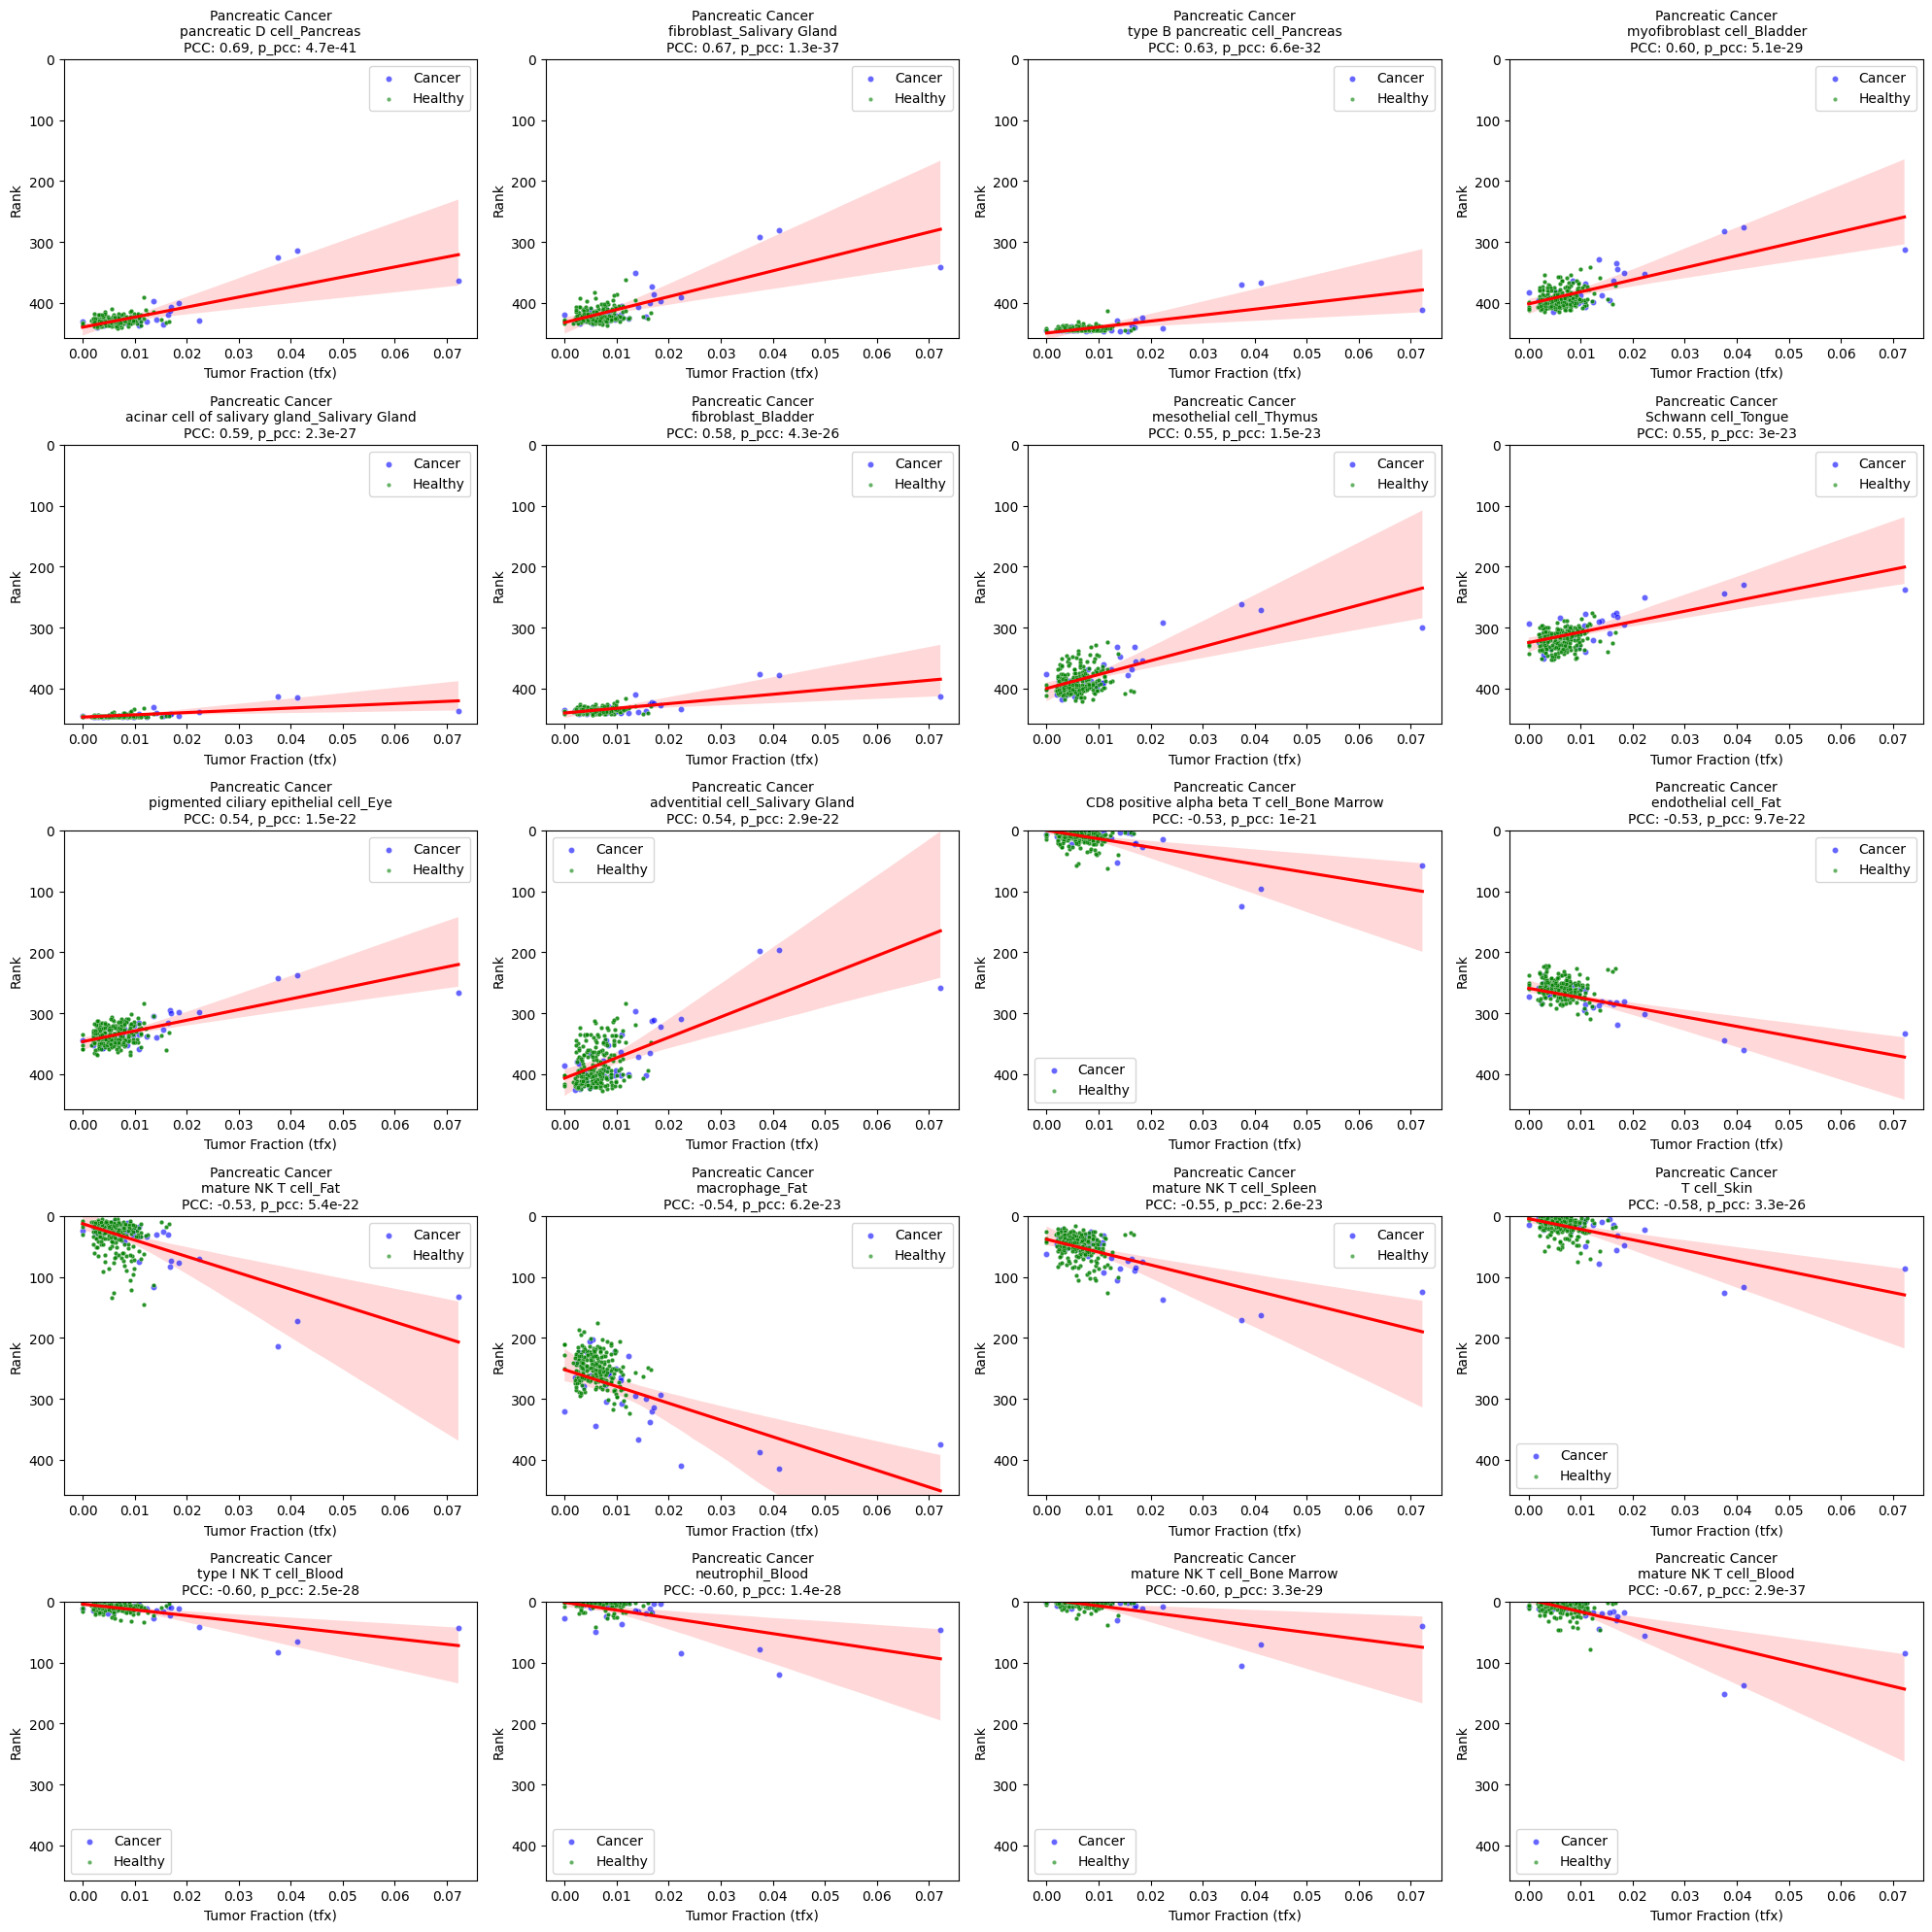

Ovarian Cancer


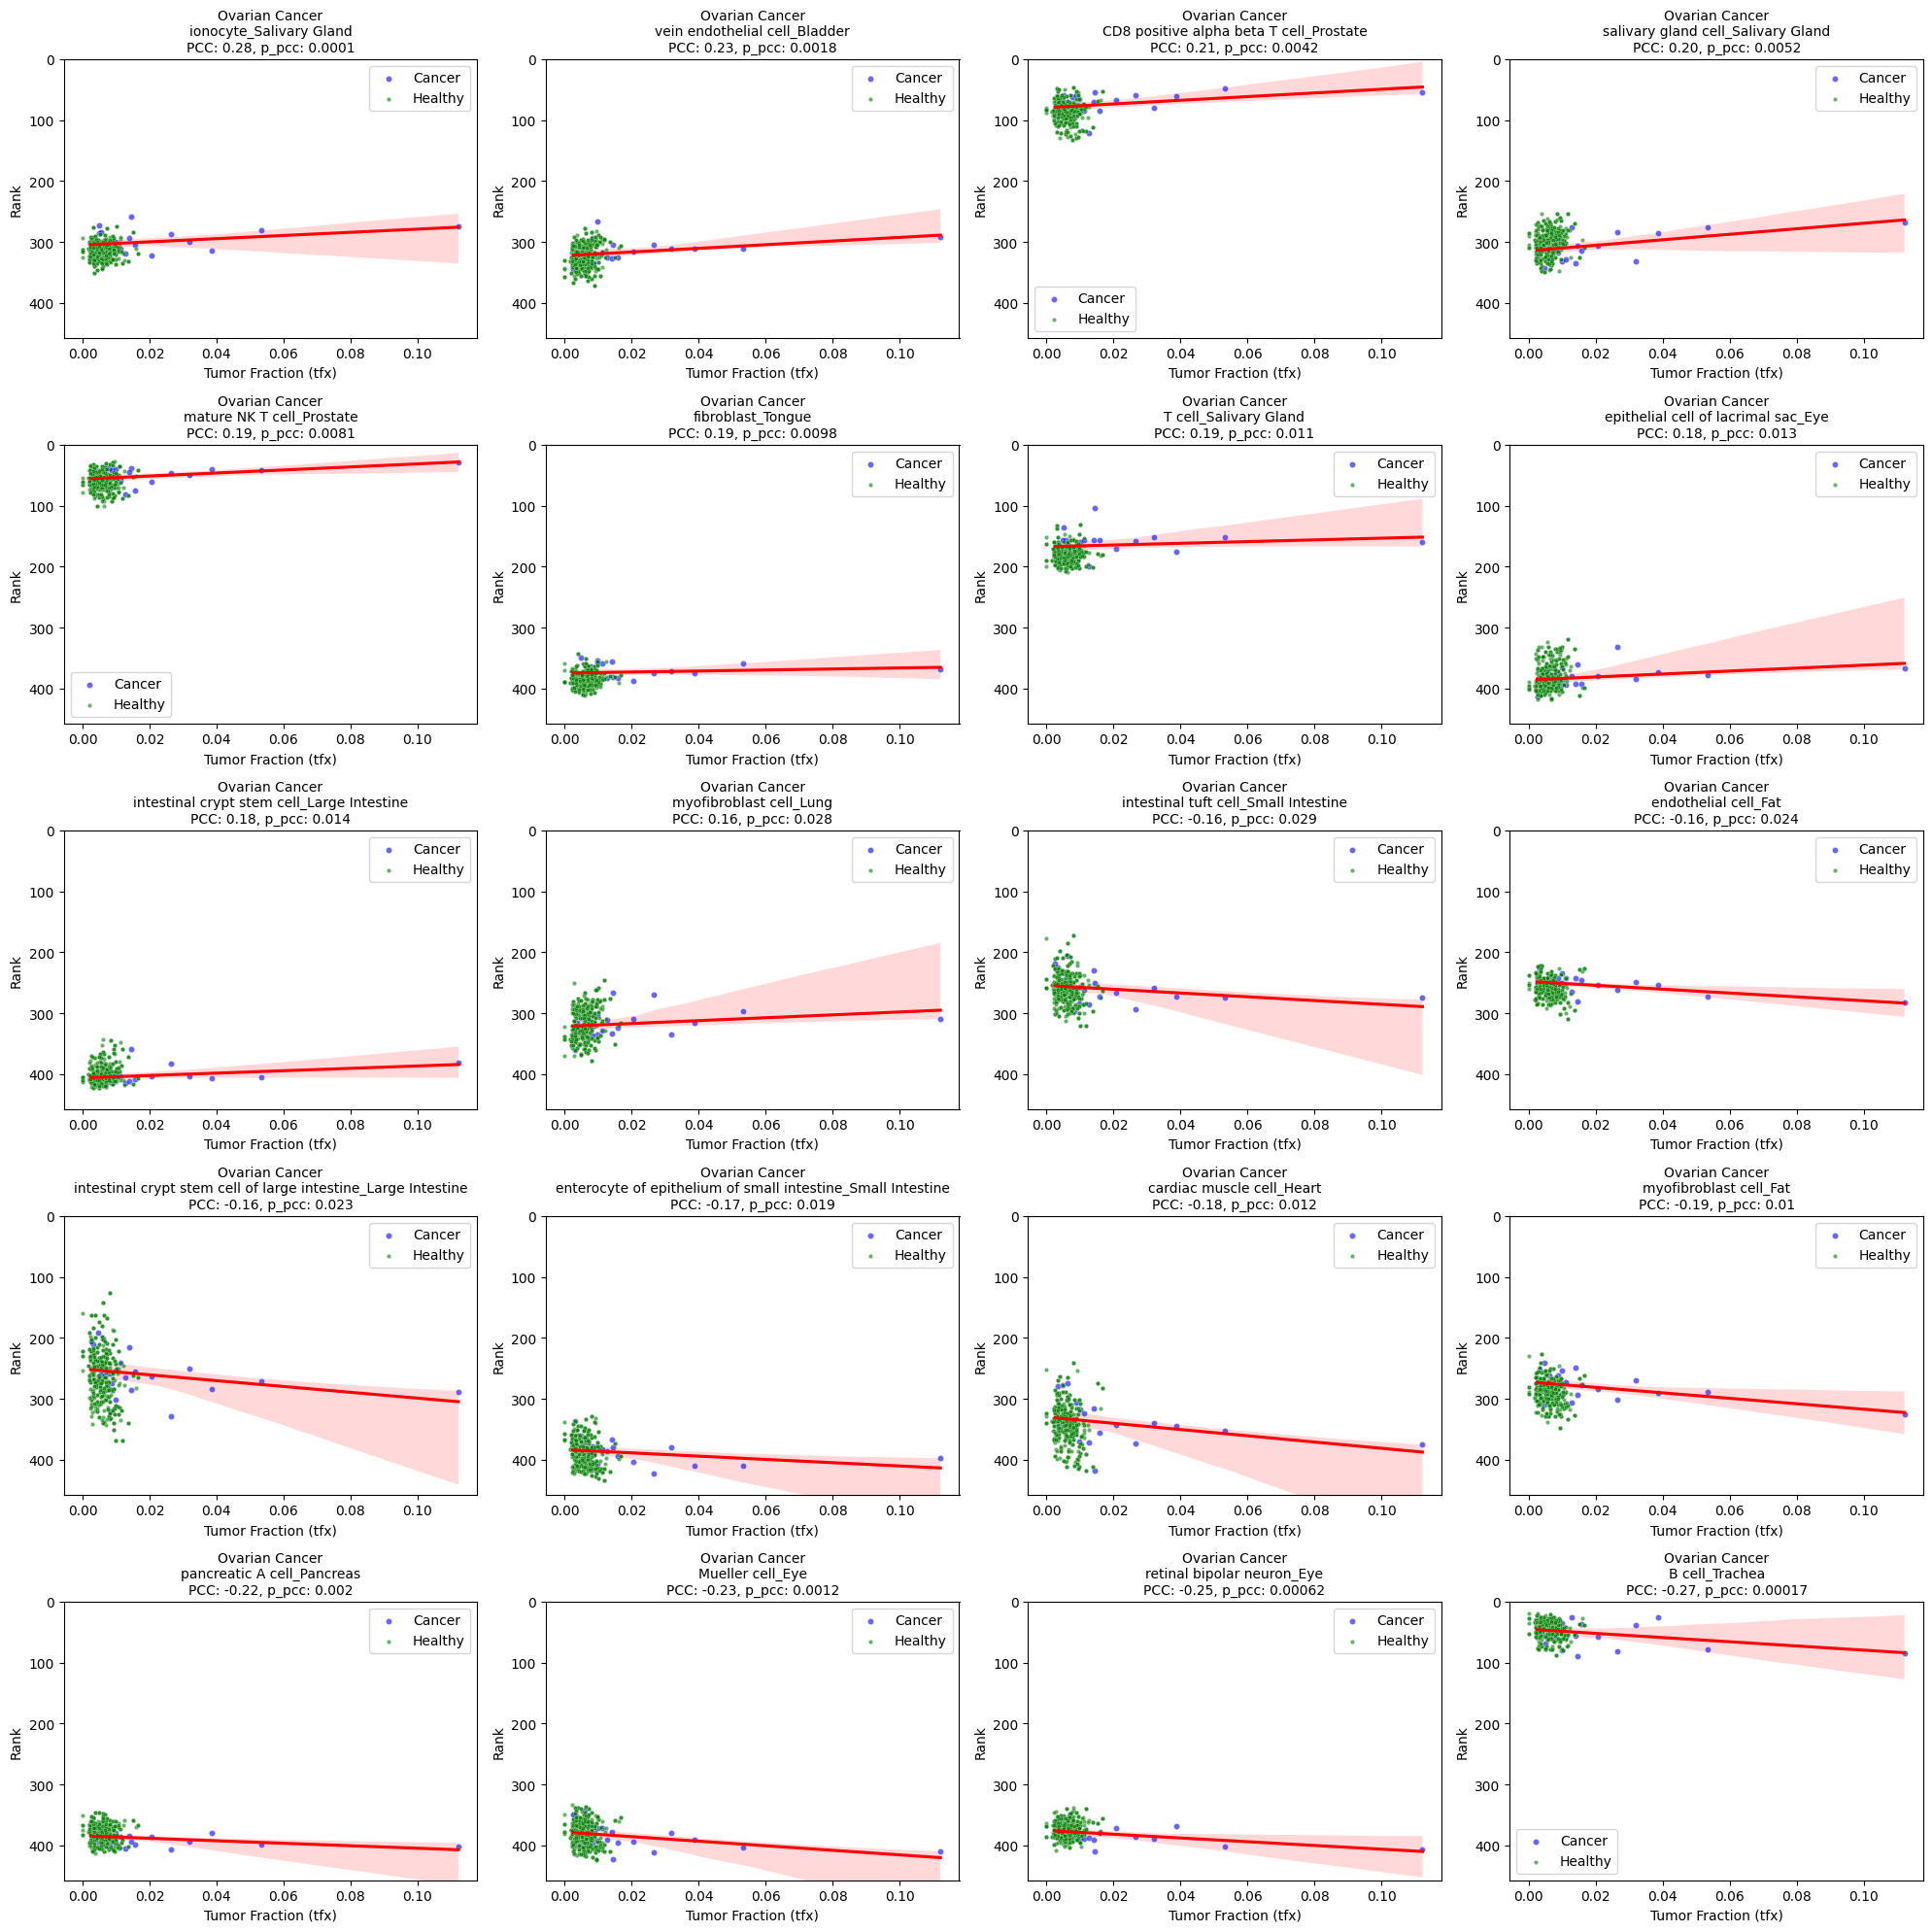

Bile Duct Cancer


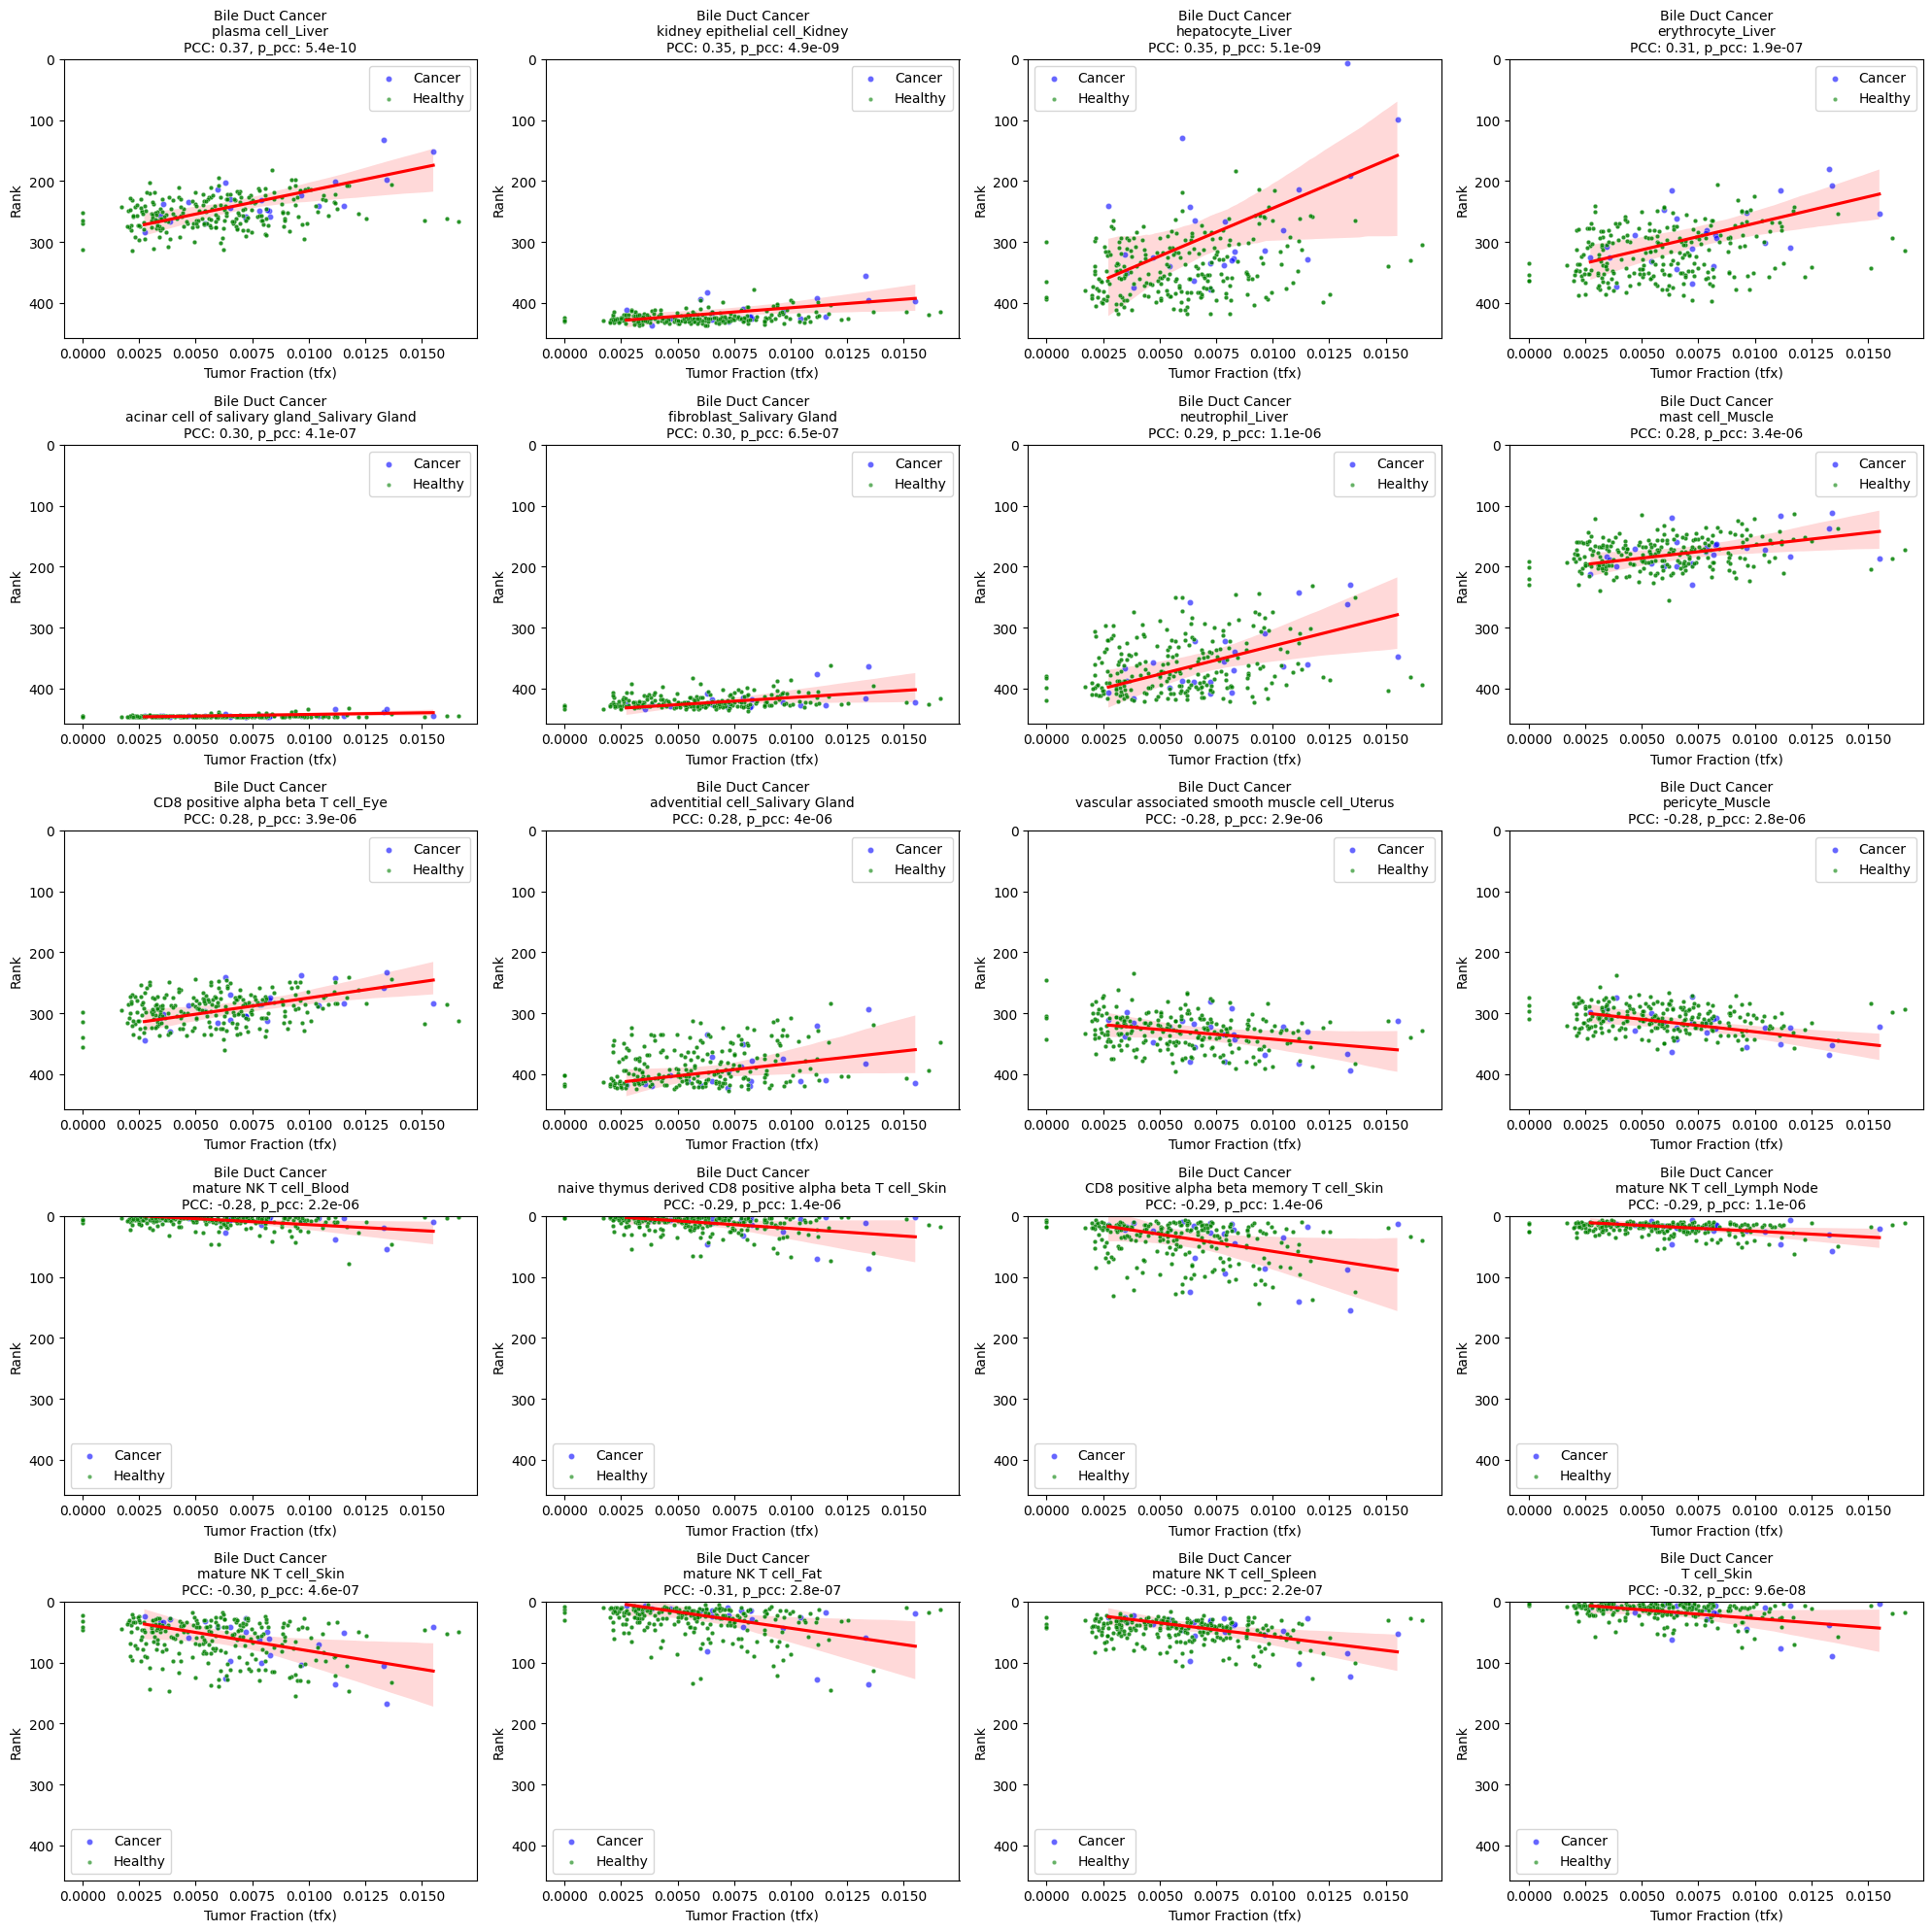

Colorectal Cancer


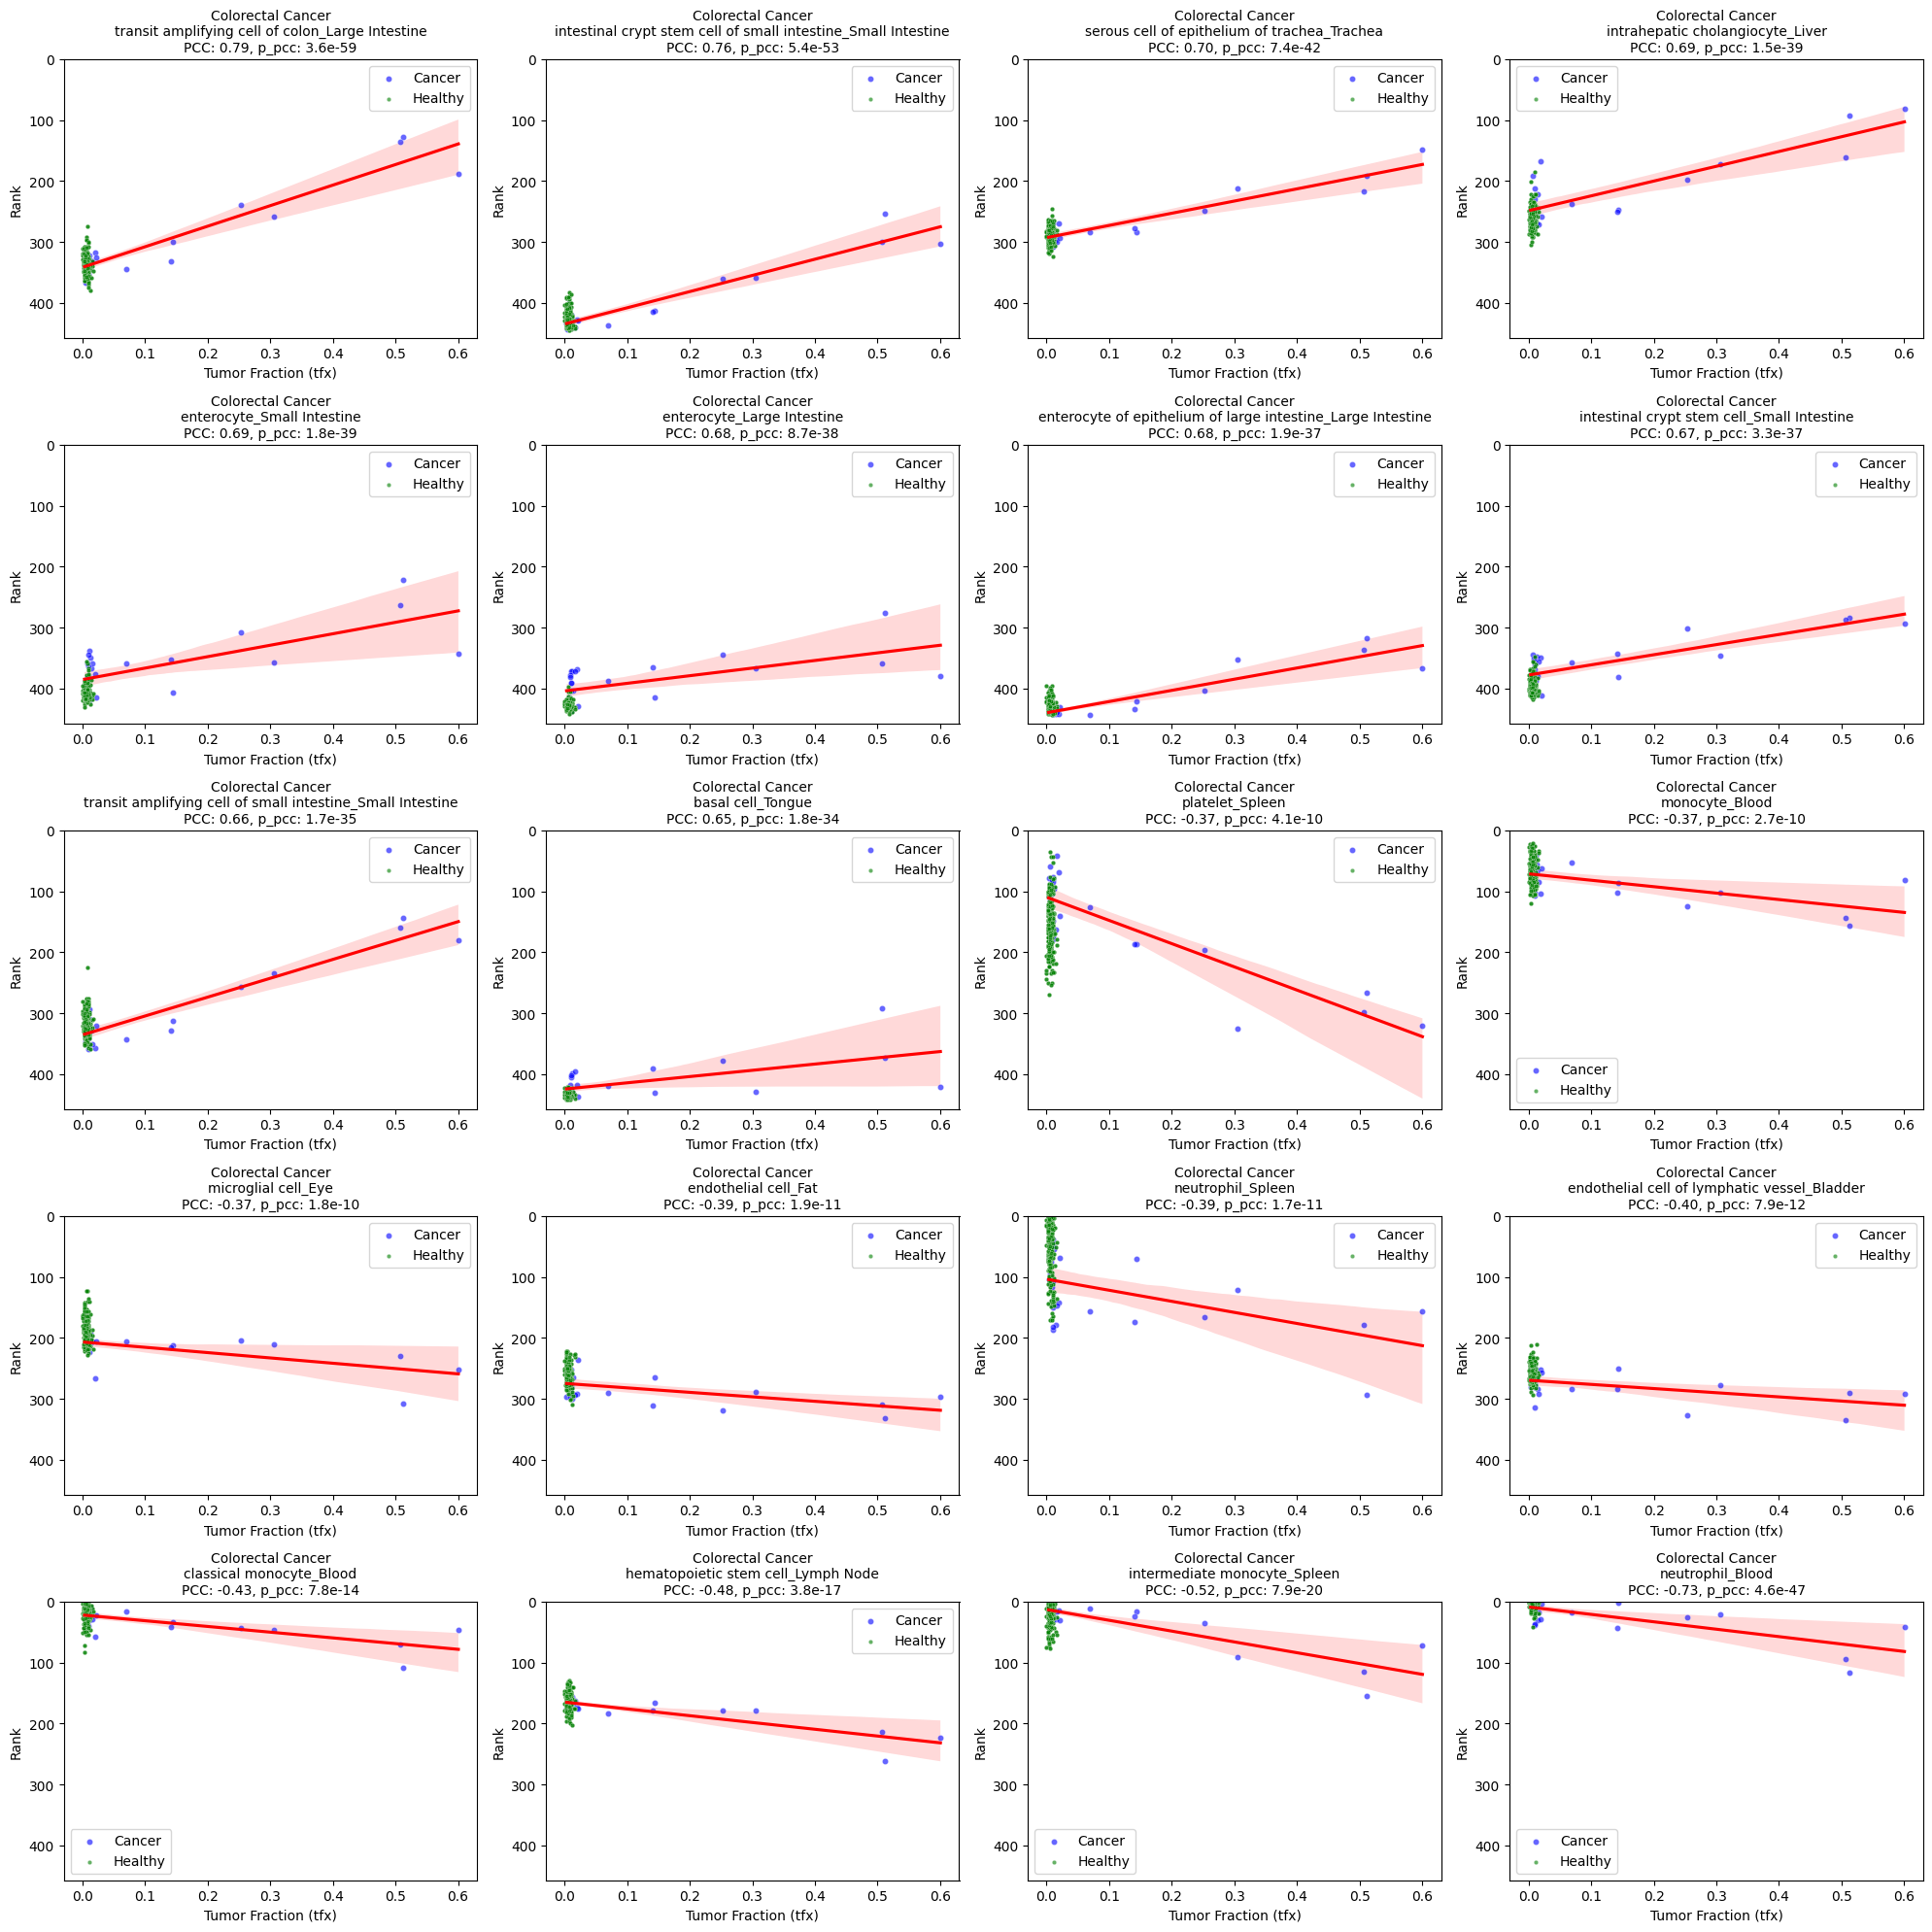

Gastric cancer


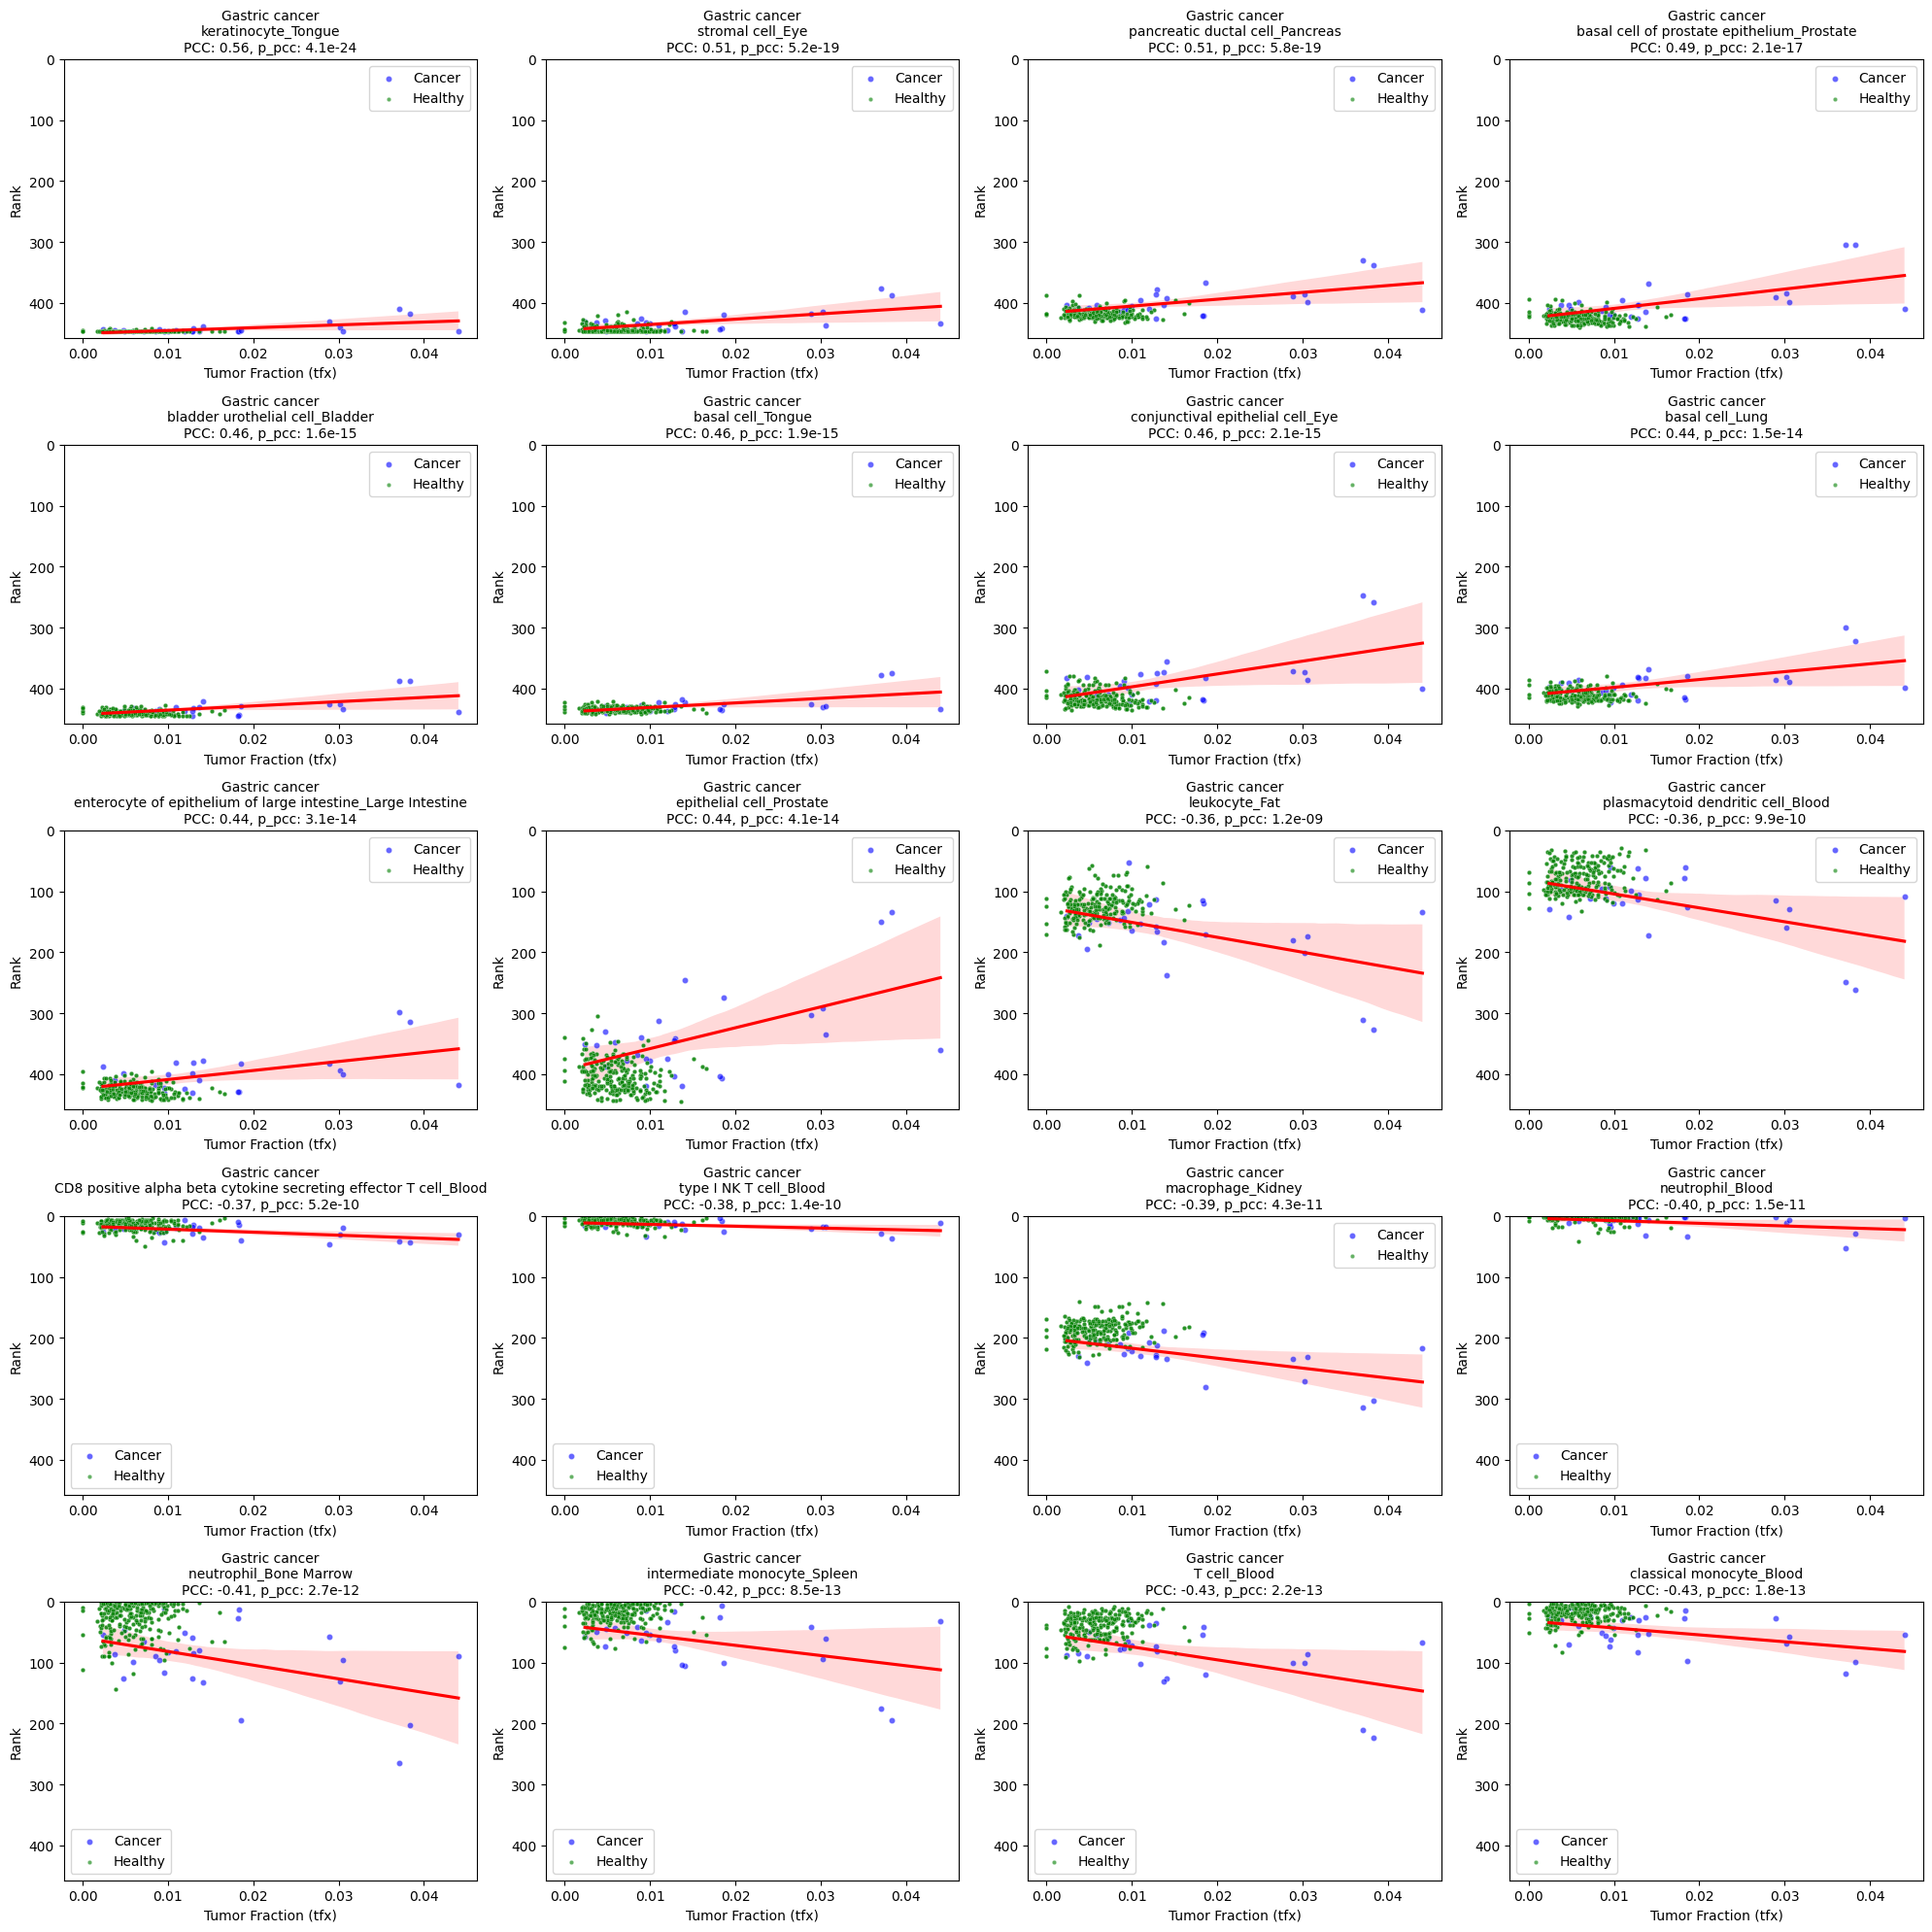

In [17]:
for cancer_type in dic.keys():
    print(cancer_type)
    # Create a figure and a set of subplots
    fig, axs = plt.subplots(5, 4, figsize=(20, 20))

    # Flatten axs array for easy iteration
    axs = axs.flatten()
    plot_count = 0
    for cell_type_tissue in plot_dic[cancer_type].keys():
        p_value_pcc = plot_dic[cancer_type][cell_type_tissue]['p_value']
        PCC = plot_dic[cancer_type][cell_type_tissue]['PCC']
        df = plot_dic[cancer_type][cell_type_tissue]['df']

        # add healthy ranks if wanted
        healthy = data[(data['status'] == 'Healthy') & (data['cell_type_tissue'] == cell_type_tissue)]
        merged = pd.concat([df, healthy], ignore_index=True)

        # Set up the color palette for the two groups
        palette = {'Cancer': 'blue', 'Healthy': 'green'}

        # Plotting on the current subplot axis, where 'group' is the column representing your two groups
        # Regression plot, invisible points alpa = 0.0
        sns.regplot(x='tfx', y='rank', data=merged[merged['status'] == cancer_type],
                    scatter_kws={'color': palette['Cancer'], 's': 20, 'alpha': 0.0},
                    line_kws={'color': 'red'}, ax=axs[plot_count])

        # Plotting for Cancer group - dummy - 
        sns.scatterplot(x='tfx', y='rank', data=merged[merged['status'] == cancer_type],
                        color=palette['Cancer'], s=20, alpha=0.6, label='Cancer', ax=axs[plot_count])
        
        # Plotting for Healthy group
        sns.scatterplot(x='tfx', y='rank', data=merged[merged['status'] == 'Healthy'],
                        color=palette['Healthy'], s=10, alpha=0.6, label='Healthy', ax=axs[plot_count])

        nr_cell_type_tissues = len(data['cell_type_tissue'].unique())
        # Set the title and labels for each subplot
        axs[plot_count].set_title(f'{cancer_type}\n{cell_type_tissue}\nPCC: {PCC:.2f}, p_pcc: {p_value_pcc:.2g}', fontsize=10)
        axs[plot_count].set_xlabel('Tumor Fraction (tfx)')
        axs[plot_count].set_ylabel('Rank')
        axs[plot_count].set_ylim(0, nr_cell_type_tissues + 10)
        axs[plot_count].invert_yaxis()  # Invert y-axis to show higher rank at the top
        
        plot_count += 1

    # Adjust display settings
    pd.set_option('display.width', 1000)
    pd.set_option('display.max_columns', None)
    plt.tight_layout()

    # Show the final plot
    plt.show()


In [18]:
from IPython.display import display, HTML

display(HTML("""
<style>
    div.output_area {
        max-height: none;
        height: auto;
    }
</style>
"""))


In [14]:
dic["Lung Cancer"].keys()

dict_keys(['duct.epithelial.cell_Salivary_Gland', 'basal.cell_Tongue', 'ionocyte_Salivary_Gland', 'endothelial.cell.of.artery_Thymus', 'T.cell_Salivary_Gland', 'endothelial.cell.of.lymphatic.vessel_Muscle', 'radial.glial.cell_Eye', 'intrahepatic.cholangiocyte_Liver', 'capillary.endothelial.cell_Thymus', 'vein.endothelial.cell_Tongue', 'neutrophil_Fat', 'neutrophil_Lymph_Node', 'macrophage_Fat', 'CD1c.positive.myeloid.dendritic.cell_Skin', 'macrophage_Spleen', 'neutrophil_Spleen', 'plasma.cell_Large_Intestine', 'CD1c.positive.myeloid.dendritic.cell_Lymph_Node', 'macrophage_Blood', 'neutrophil_Blood'])

In [33]:
#all cells for a cancer type
type = "Ovarian"
cancer_type = type + " Cancer" 
cancer_keys = [key for key in dic[cancer_type].keys() if type in key]
# Create a figure and a set of subplots
number_plots = len(cancer_keys)
print(number_plots)
cancer_keys
cancer_type

0


'Ovarian Cancer'

In [28]:
4*n_row_plots

40

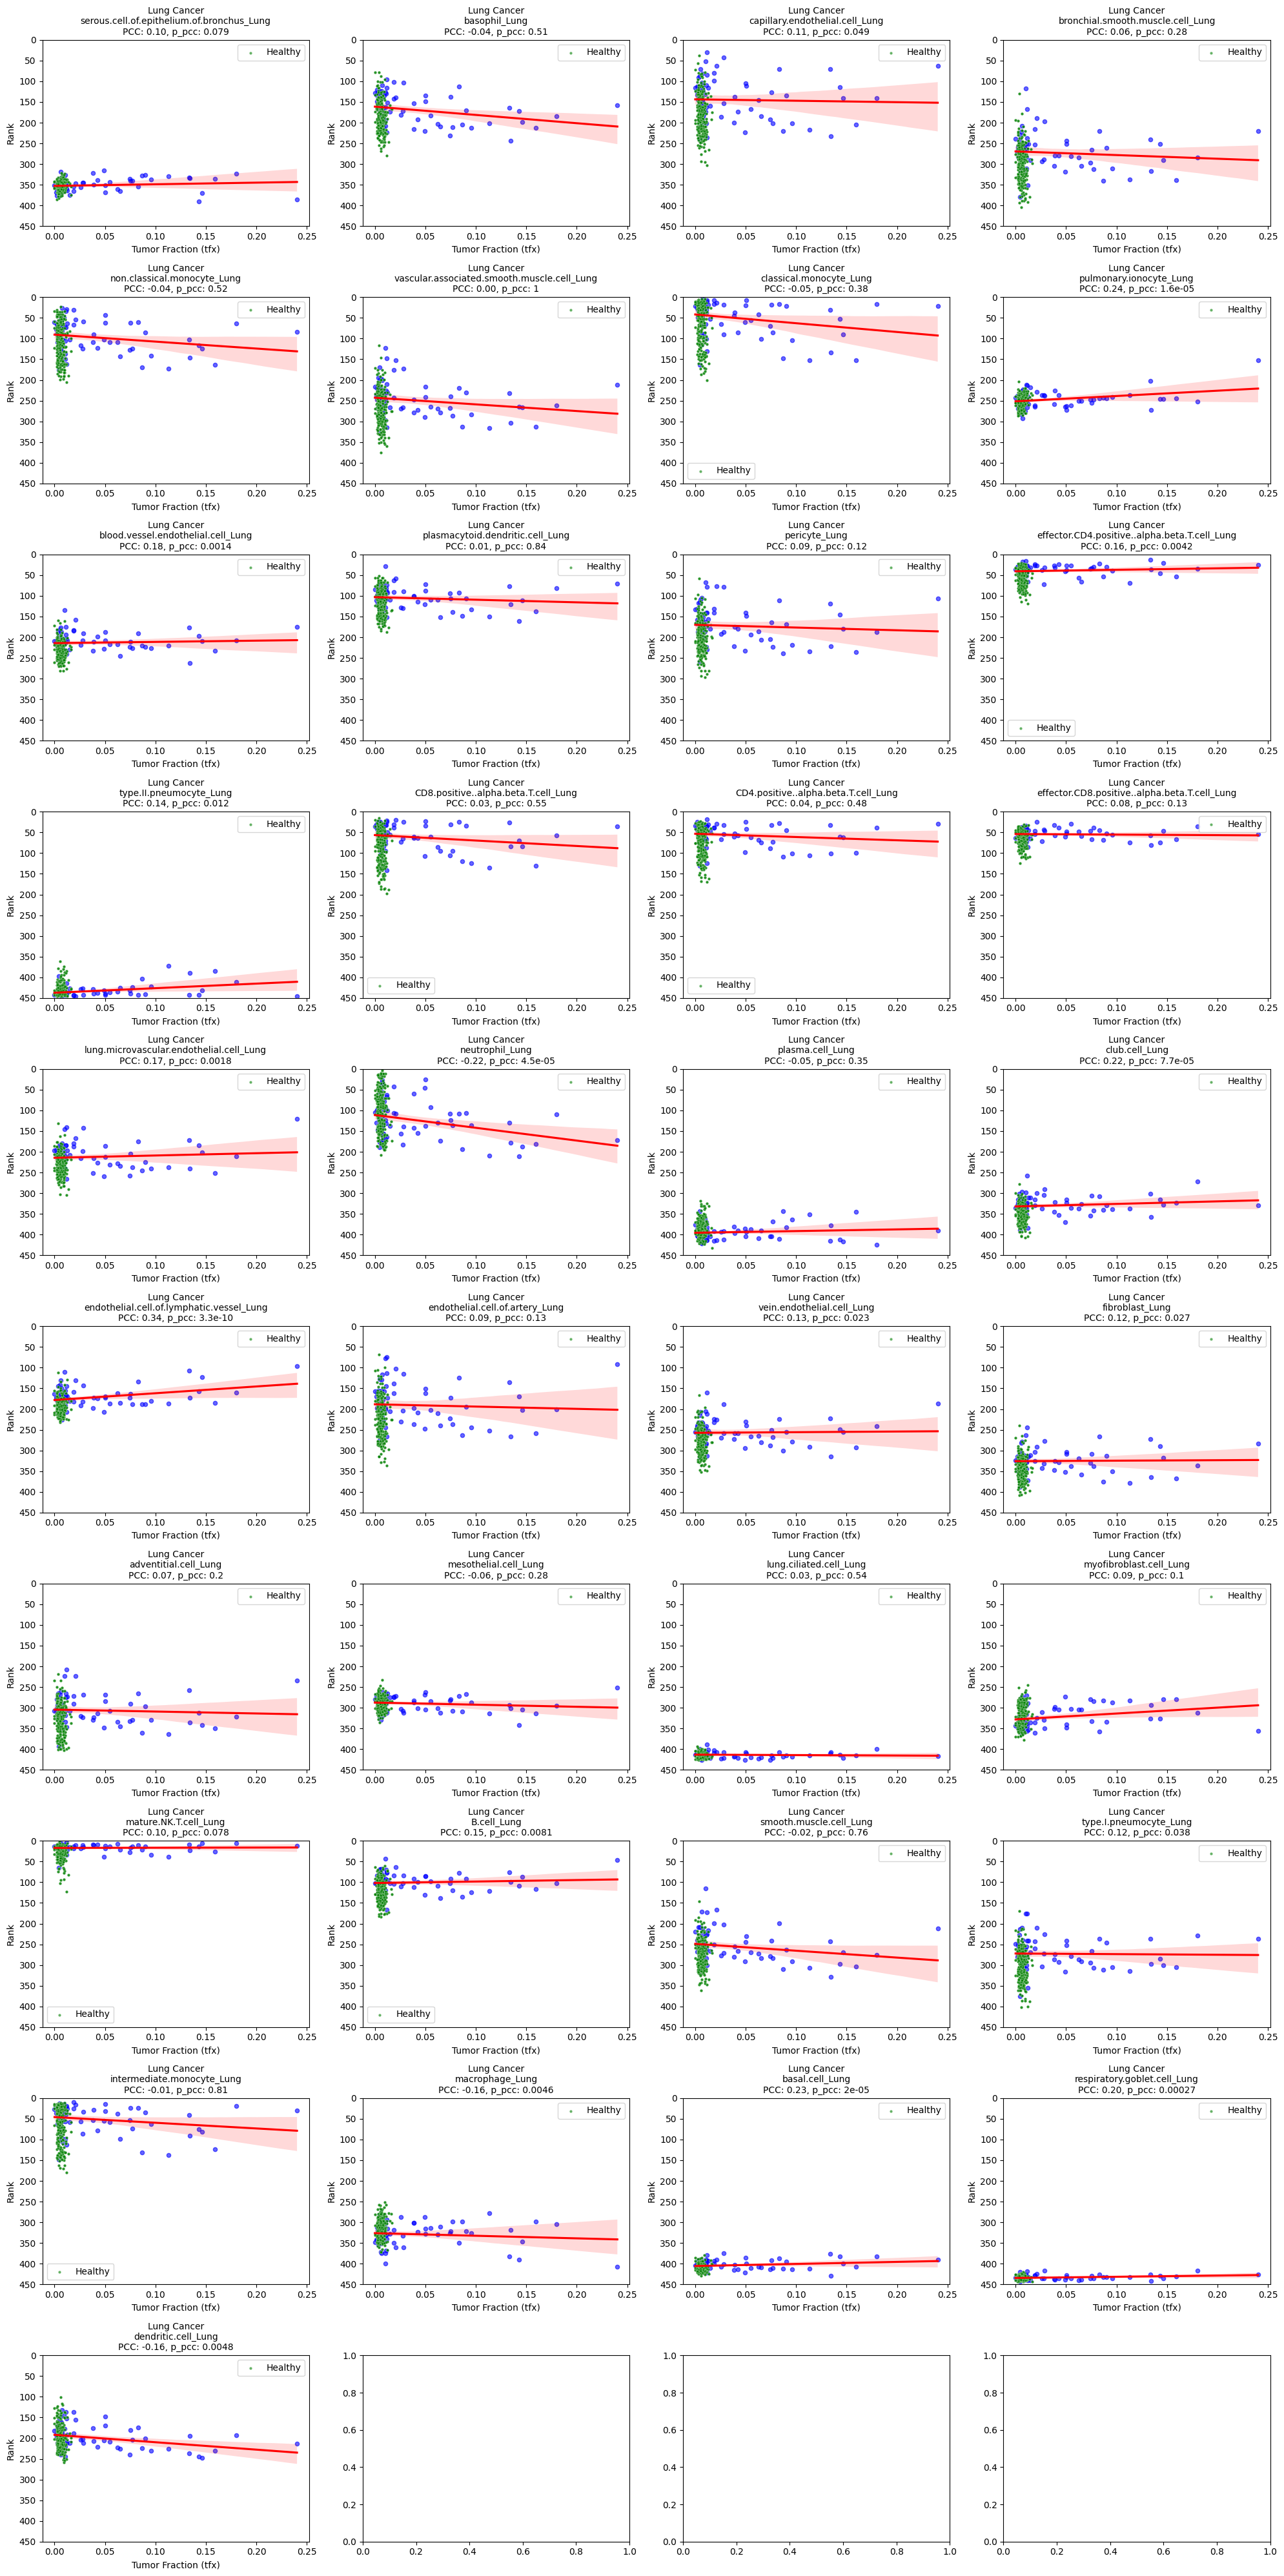

In [29]:

n_col_plots = 4
n_row_plots =round((number_plots / n_col_plots)+1)

fig, axs = plt.subplots(n_row_plots, 4, figsize=(20, 4*n_row_plots))

# Flatten axs array for easy iteration
axs = axs.flatten()
plot_count = 0
for cell_type in cancer_keys:
    p_value_pcc = dic[cancer_type][cell_type]['p_value']
    PCC = dic[cancer_type][cell_type]['PCC']
    df = dic[cancer_type][cell_type]['df']

    # add healthy ranks if wanted
    healthy = data[(data['status'] == 'Healthy') & (data['cell_type'] == cell_type)]
    merged = pd.concat([df, healthy], ignore_index = True)

   # Set up the color palette for the two groups
    palette = {'Cancer': 'blue', 'Healthy': 'green'}
    
    # Plotting on the current subplot axis, where 'group' is the column representing your two groups
    sns.regplot(x='tfx', y='rank', data=merged[merged['status'] == cancer_type],
                scatter_kws={'color': palette['Cancer'], 's': 20, 'alpha': 0.6},
                line_kws={'color': 'red'}, ax=axs[plot_count])
    
    sns.scatterplot(x='tfx', y='rank', data=merged[merged['status'] == 'Healthy'],
                   color=palette['Healthy'], s=10, alpha=0.6, label='Healthy', ax=axs[plot_count])


    # Set the title and labels for each subplot
    axs[plot_count].set_title(f'{cancer_type}\n{cell_type}\nPCC: {PCC:.2f}, p_pcc: {p_value_pcc:.2g}', fontsize=10)
    axs[plot_count].set_xlabel('Tumor Fraction (tfx)')
    axs[plot_count].set_ylabel('Rank')
    axs[plot_count].set_ylim(0, 450)
    axs[plot_count].invert_yaxis()  # Invert y-axis to show higher rank at the top
    
    # Optional: Add a legend for the groups
    #axs[plot_count].legend(loc='best')
    
    plot_count += 1

# Adjust display settings
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
plt.tight_layout()

# Show the final plot
plt.show()